In [1]:
import sys
import os.path as op
    
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
import pickle
from scipy import stats


module_path = op.abspath(op.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from data_analysis.functions_preprocessing import split_raws

# Create path to the folder "behavioral"
behav_dir = "/net/store/nbp/projects/hyperscanning/study_project/NBP_Hyperscanning/data_analysis/behavioral_data"

# Create a list of path names that end with .csv
behav_path = op.join(behav_dir, "203.csv")#test


df = pd.read_csv(behav_path)


df.head()

In /net/store/nbp/projects/hyperscanning/study_project/programming_tools/miniconda3/envs/hyperscanning/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /net/store/nbp/projects/hyperscanning/study_project/programming_tools/miniconda3/envs/hyperscanning/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /net/store/nbp/projects/hyperscanning/study_project/programming_tools/miniconda3/envs/hyperscanning/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /net/store/nbp/projects/hyperscanning/study_project

,pair,condition,block,trial,subject,tapnr,ttap,jitter,player_start_first
0,203,blind,1,1,1,1,3.488252,0.075,1
1,203,blind,1,1,1,2,4.149057,0.075,1
2,203,blind,1,1,1,3,4.818118,0.075,1
3,203,blind,1,1,1,4,5.474000,0.075,1
4,203,blind,1,1,1,5,6.185978,0.075,1


In [2]:
df.shape

(5400, 9)

In [3]:
def calculate_alpha(df):
    """
    Calculates the circular tapping synchrony measure as defined in Novembre et al. (2017).
    """

    # calculate the inter-person difference P(x) T(n) - P(y) T(n)
    # from both subjects' perspectives
    df = df.sort_values(['trial', 'tapnr'])
    df['diff_inter'] = df['ttap'].diff()
    df.iloc[::2, df.columns.get_loc('diff_inter')] = df['ttap'].diff(-1)

    # calculate the intra-person difference P(x) T(n + 1) - P(x) T(n)
    df['diff_intra'] = abs(df.groupby(['subject', 'trial'])['ttap'].diff(-1))  # .fillna(0)

    # calculate alpha and linearized alpha for all taps
    df['alpha'] = abs(df['diff_inter'] / df['diff_intra']) * 360
    df['alpha_lin'] = abs(180 - abs(df['alpha'] - 180))
    # TODO: discuss the linearization/ asynchronous trials. I found that there are single taps where the circular measure is larger than 360°
    # This means theoretically that the interperson diff is way bigger than the intra person diff, meaning that P1 made
    # the next tap already while P2 "misses" out one tap. By doing % 360, i define that these asynchronous trials are valid
    # and people can be synchronous, even if one tap was missed out by a person.
    # We could also instead remove these trials by removing the `% 360`, and cropping all df["alpha"] > 360 afterwards.
    
    return df


df = calculate_alpha(df)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    ddd = df[["subject", "trial", "tapnr", "diff_intra", "diff_inter", "alpha", "alpha_lin"]]
    print(ddd.sort_index())

      subject  trial  tapnr  diff_intra  diff_inter        alpha    alpha_lin
0           1      1      1    0.660805    0.108922    59.339627    59.339627
1           1      1      2    0.669061    0.055085    29.639412    29.639412
2           1      1      3    0.655882    0.066063    36.260705    36.260705
3           1      1      4    0.711978    0.072040    36.425888    36.425888
4           1      1      5    0.664024    0.111816    60.620893    60.620893
5           1      1      6    0.657998    0.120869    66.129240    66.129240
6           1      1      7    0.715177    0.141863    71.409775    71.409775
7           1      1      8    0.631029    0.197791   112.839022   112.839022
8           1      1      9         NaN    0.153093          NaN          NaN
9           2      1      1    0.714642   -0.108922    54.869318    54.869318
10          2      1      2    0.658083   -0.055085    30.133860    30.133860
11          2      1      3    0.649905   -0.066063    36.594180

<AxesSubplot:>

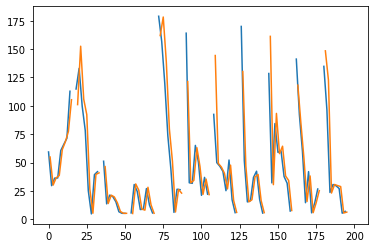

In [4]:

df.reset_index()["alpha_lin"].iloc[:200:2].plot()
df.reset_index()["alpha_lin"].iloc[1:200:2].plot()

In [5]:
def remove_outliers(df, exclude_stddev):
    """Remove all trials where the average alpha is `exclude_sttdev` sttdevs larger or
    smaller than the mean."""
    
    # calculate the mean alpha for each trial
    means = df.groupby(['trial'])["alpha"].mean()
    
    # define the upper and lower bounds, based on the mean and stddev of these means
    lower_bound = means.mean() - exclude_stddev * means.std()
    upper_bound = means.mean() + exclude_stddev * means.std()
    
    # filter the means so only the trials within the defined bounds remain
    good_trials = means[(lower_bound < means) & (means < upper_bound)]
    
    # return the df filtered for only the good trials
    return df[df["trial"].isin(good_trials.index)]


df_clean = remove_outliers(df, 1)
df_clean.shape

(4914, 13)

In [6]:
subject_dir = '/net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/'


pair = 202
participant = 0

# 1.2 define the subjects id and its path
subj_id = "sub-{0}_p-{1}".format(pair, participant)
subs_path = subject_dir + "sub-{0}/eeg/sub-{0}_task-hyper_eeg.fif".format(pair)
behav_path = op.join(behav_dir, str(pair) + ".csv")

# load the data
combined_raw = mne.io.read_raw_fif(subs_path, preload=True)


Opening raw data file /net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/sub-202/eeg/sub-202_task-hyper_eeg.fif...


<ipython-input-6-2f01f4ed25ef>:13: RuntimeWarning: This filename (/net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/sub-202/eeg/sub-202_task-hyper_eeg.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  combined_raw = mne.io.read_raw_fif(subs_path, preload=True)


Isotrak not found
    Range : 0 ... 3725311 =      0.000 ...  3637.999 secs
Ready.
Opening raw data file /net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/sub-202/eeg/sub-202_task-hyper_eeg-1.fif...
Isotrak not found
    Range : 3725312 ... 5675445 =   3638.000 ...  5542.427 secs
Ready.
Reading 0 ... 5675445  =      0.000 ...  5542.427 secs...


In [7]:
EVENT_DICT = {'s1/t1':6, 's1/t2':7, 's1/t3':8, 's1/t4':9, 's1/t5':10, 's1/t6':11, 's1/t7':12, 's1/t8':13, 's1/t9':14,
              's2/t1':15, 's2/t2':16, 's2/t3':17, 's2/t4':18, 's2/t5':19, 's2/t6':20, 's2/t7':21, 's2/t8':22, 's2/t9':23}

INV_EVENT_DICT = {str(val): key for key, val in EVENT_DICT.items()}


EVENT_DICT

{'s1/t1': 6,
 's1/t2': 7,
 's1/t3': 8,
 's1/t4': 9,
 's1/t5': 10,
 's1/t6': 11,
 's1/t7': 12,
 's1/t8': 13,
 's1/t9': 14,
 's2/t1': 15,
 's2/t2': 16,
 's2/t3': 17,
 's2/t4': 18,
 's2/t5': 19,
 's2/t6': 20,
 's2/t7': 21,
 's2/t8': 22,
 's2/t9': 23}

In [8]:
# 2.2. Look for events in raw
#raw.info

events = mne.find_events(combined_raw, shortest_event=1)
events

6648 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 36 37 38 39 40 41 42 43 44 45 46 48 49]


array([[ 191183,       0,       1],
       [ 191252,       0,       2],
       [ 202497,       0,       2],
       ...,
       [5636326,       0,      23],
       [5636336,       0,      49],
       [5638973,       0,      46]])

In [9]:
def remove_ghost_triggers(df):
    """Removes Ghost Triggers from an event dataframe, based on the logic that
    all taps from each person should have a larger code than the previous tap
    from the same person."""
    
    # split the tap dataframe up for each subject
    for subj in [1,2]:
        subj_df = df[df['event_name'].str.startswith("s" + str(subj))]
        subj_df = subj_df.sort_values(['sample'])
    
    
        # look only at the indices and event codes from one person
        indices = subj_df["event_index"].to_numpy()
        event_codes = subj_df["event_code"].to_numpy()
    
        for i in range(len(indices)):
        
            # look at the previous code, current code and the current index
            previous_code = event_codes[i-1]
            current_code = event_codes[i]
            current_index = indices[i]
        
            # the initial tap codes are allowed to be smaller than the previous taps
            #if current_code not in (6, 15):
            # FIXME: The above logic leaves out ghost triggers with code 6 or 15. we must make sure these are also included.
            # i fix this in the below statement. However, this was not run in python, so if there are any errors, this might be the line to correct
            is_start_tap = ((current_code == 6) and (previous_code == 14)) or ((current_code == 15) and (previous_code == 23))
            if not is_start_tap:
            
                # for all other taps, if the code is not one step higher than the
                # previous trigger, it's a ghost trigger.
                if current_code != previous_code + 1:
                
                    # then we remove the ghost trigger from the orginial dataframe
                    df = df[df["event_index"] != current_index]
                    
                    # replace the ghost trigger value in event codes, so the next
                    # iteration will reference the last valid trigger.
                    event_codes[i] = event_codes[i-1]
                
    return df


In [10]:
def create_event_df(raw):
    """Reads events, assigns them event names and creates an event dataframe."""
    
    events = mne.find_events(raw, shortest_event=1)

    # create a pandas DataFrame to make working with events easier
    df_events = pd.DataFrame(events[:, (0, 2)])
    df_events.columns = ('sample','event_code')
    df_events['event_index'] = range(len(df_events))
    
    # add the trial number to later match the df with the behavioral data
    df_events['event_trial'] = 0
    
    # each time we see the "trial start" trigger, we increase the trial number
    for idx, row in df_events.iterrows():
        if row['event_code'] == 48:
            df_events['event_trial'][idx:] += 1

    # filter out the tapping events only
    df_events = df_events[df_events['event_code'].isin(EVENT_DICT.values())]

    # create a column including the event names
    df_events['event_name'] = [INV_EVENT_DICT[str(code)] for code in df_events['event_code']]
    
    return df_events


def events_from_event_df(df):
    """Sort a combined event dataframe and return it to a mne-style numpy array."""
    df = df.sort_values(['event_index'])
    events = np.vstack([df['sample'],
                        np.zeros(len(df)),
                        df['event_code']]).astype(int).T
    
    return events


def join_event_dfs(event_df, behavioral_df):
    """Join a behavioral and an event dataframe."""
    
    # sort both dataframes after trial, subject, tap
    event_df = event_df.sort_values(['event_trial', 'event_name'])
    behavioral_df = behavioral_df.sort_values(['trial', 'subject', 'tapnr'])
    
    # reset the event df index to the behavioral df
    event_df.index = behavioral_df.index
    
    return event_df.join(behavioral_df).drop(columns=['event_trial'])

In [11]:
event_df = create_event_df(combined_raw)
ghost_events = event_df['event_code'].value_counts()
ghost_events

6648 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 36 37 38 39 40 41 42 43 44 45 46 48 49]


20    301
23    300
19    300
12    300
16    300
9     300
13    300
17    300
21    300
6     300
10    300
14    300
18    300
22    300
7     300
11    300
15    300
8     300
Name: event_code, dtype: int64

In [12]:
event_df = create_event_df(combined_raw)
event_df = remove_ghost_triggers(event_df)
behavioral_df = calculate_alpha(pd.read_csv(behav_path))

joint_df = join_event_dfs(event_df, behavioral_df)

clean_df = remove_outliers(joint_df, exclude_stddev=2)

events = events_from_event_df(joint_df)

#print(events)
#clean_df.sort_index()

6648 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 36 37 38 39 40 41 42 43 44 45 46 48 49]


In [13]:
int(5635492 + (10.330310 - 9.516107) * 1024) # should be equal to 5636326

5636325

# Answer the questions from the "Behavioral Data" Document

In [14]:
all_subs = pd.DataFrame()

for subs in ['202','203','204','205','206','207','208','209','211','212']:
    behav_path = op.join(behav_dir, "{}.csv".format(subs))#test
    
    # calculate the alpha on all trials
    df = calculate_alpha(pd.read_csv(behav_path))
    
    # our filtering condition: take vp 1 for odd trials and vp 2 for even trials
    df = df[df["trial"]%2 != df["subject"] - 1]
    
    bad_trls = len(df[df["alpha"] > 360]["trial"].unique())
    per_a = bad_trls / df["trial"].max() * 100
    print("Pair {0} - Percent of incorrect trials: {1}%".format(subs, per_a))
    
    
    all_subs = all_subs.append(df)
    

all_subs["unique_trials"] = all_subs["pair"].astype(str) + "-" + all_subs["trial"].astype(str)
bad_trls = len(all_subs[all_subs["alpha"] > 360]["unique_trials"].unique())
per_a = bad_trls / len(all_subs["unique_trials"].unique()) * 100
print("All subs - Percent of incorrect trials: {0} %".format(per_a))
all_subs.index = range(len(all_subs))
#print(all_subs["unique_trials"])

Pair 202 - Percent of incorrect trials: 6.0%
Pair 203 - Percent of incorrect trials: 9.333333333333334%
Pair 204 - Percent of incorrect trials: 11.333333333333332%
Pair 205 - Percent of incorrect trials: 3.3333333333333335%
Pair 206 - Percent of incorrect trials: 10.666666666666668%
Pair 207 - Percent of incorrect trials: 9.666666666666666%
Pair 208 - Percent of incorrect trials: 18.666666666666668%
Pair 209 - Percent of incorrect trials: 8.666666666666668%
Pair 211 - Percent of incorrect trials: 25.0%
Pair 212 - Percent of incorrect trials: 31.333333333333336%
All subs - Percent of incorrect trials: 13.4 %


In [15]:
# get all taps where one person tapped twice before the other person did
all_subs[all_subs["alpha"] > 360]

,pair,condition,block,trial,subject,tapnr,ttap,jitter,player_start_first,diff_inter,diff_intra,alpha,alpha_lin,unique_trials
76,202,blind,1,9,1,5,7.236328,0.075,1,-0.829144,0.810793,368.148058,8.148058,202-9
78,202,blind,1,9,1,7,8.932238,0.075,1,-0.872157,0.857896,365.984364,5.984364,202-9
79,202,blind,1,9,1,8,9.790134,0.075,1,-0.899273,0.809975,399.689234,39.689234,202-9
91,202,blind,1,11,1,2,4.665786,0.100,2,-1.208054,0.994704,437.214950,77.214950,202-11
171,202,blind,1,20,2,1,4.929792,0.050,1,1.256341,0.822949,549.587713,189.587713,202-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26799,212,blind,12,278,2,7,6.272013,0.050,2,0.735059,0.360615,733.805408,373.805408,212-278
26800,212,blind,12,278,2,8,6.632628,0.050,2,0.741067,0.367277,726.384307,366.384307,212-278
26856,212,blind,12,285,1,1,4.217153,0.100,2,0.799759,0.414336,694.878836,334.878836,212-285
26910,212,blind,12,291,1,1,3.904741,0.100,2,0.623695,0.394126,569.691413,209.691413,212-291


In [16]:
# get all the trials that were affected by these double taps
len(all_subs[all_subs["alpha"] > 360]["trial"].unique())

231

# Plots

In [17]:
from scipy import stats
# set path to save plots

behav_plots = "/net/store/nbp/projects/hyperscanning/study_project/til/behavioral_plots/"

binsize = int(np.ceil(np.sqrt(len(all_subs[all_subs["alpha"] <= 360]["alpha_lin"]))))

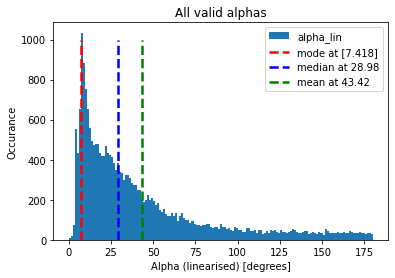

In [18]:
# get the distribution of valid alphas
all_subs[all_subs["alpha"] <= 360]["alpha_lin"].plot.hist(bins=binsize)

# plot mean, median and mode of distribution
mean = np.around(np.mean(all_subs[all_subs["alpha"] <= 360]["alpha_lin"]),decimals=2)
median = np.around(np.median(all_subs[all_subs["alpha"] <= 360]["alpha_lin"]),decimals=2)
mode,xyz3 = stats.mode(np.around(all_subs[all_subs["alpha"] <= 360]["alpha_lin"], decimals=3))


names = ["mode", "median", "mean"]
colors = ['red', 'blue', 'green']
measurements = [mode, median, mean]


for measurement, name, color in zip(measurements, names, colors):
    plt.vlines(x=measurement,ymin=0,ymax=1000, linestyle='--', linewidth=2.5, 
                label='{0} at {1}'.format(name, measurement), colors=color)
plt.legend();
plt.xlabel('Alpha (linearised) [degrees]')
plt.ylabel('Occurance')
plt.title("All valid alphas")

valid_alphas = plt.gcf()
pickle.dump(valid_alphas, open(behav_plots + "early_vs_late.p", 'wb'))

Text(0.5, 1.0, 'Valid alphas - tapwise')

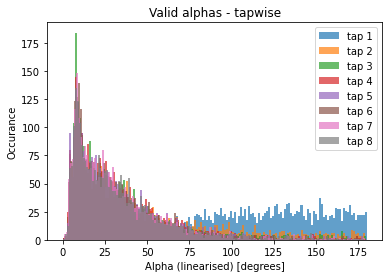

In [19]:
# get all valid alphas, group them by tapnr
small_subs = all_subs[all_subs["alpha"] <= 360]

small_subs.groupby("tapnr")["alpha_lin"].plot.hist(bins=binsize, alpha=.7)
plt.legend(['tap 1','tap 2','tap 3','tap 4','tap 5','tap 6','tap 7','tap 8'])

plt.xlabel('Alpha (linearised) [degrees]')
plt.ylabel("Occurance")
plt.title('Valid alphas - tapwise')

In [20]:
# Plot first 1.5s taps vs last 1.5s taps
# save time of first and last tap per trial
first_tap = all_subs.index - all_subs.index[all_subs.index%9]
all_subs["first_tap"] = all_subs["ttap"][first_tap].to_numpy()
last_tap = all_subs.index - all_subs.index[(all_subs.index%9)] +8
all_subs["last_tap"] = all_subs["ttap"][last_tap].to_numpy()



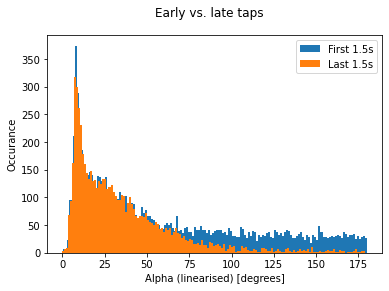

In [21]:
all_subs = all_subs[all_subs["alpha"] <= 360]

# Plot early taps (first+1.5s) vs last taps (last+1.5s)

all_subs[all_subs["ttap"] <= all_subs.first_tap+1.5 ]["alpha_lin"].plot.hist(bins=binsize)
all_subs[all_subs["ttap"] >= all_subs.last_tap-1.5 ]["alpha_lin"].plot.hist(bins=binsize)
plt.suptitle('Early vs. late taps')
plt.legend(['First 1.5s','Last 1.5s'])
plt.xlabel('Alpha (linearised) [degrees]')
plt.ylabel("Occurance")

# create fig object
early_vs_late_taps = plt.gcf()

pickle.dump(early_vs_late_taps, open(behav_plots + "early_vs_late.p", 'wb'))

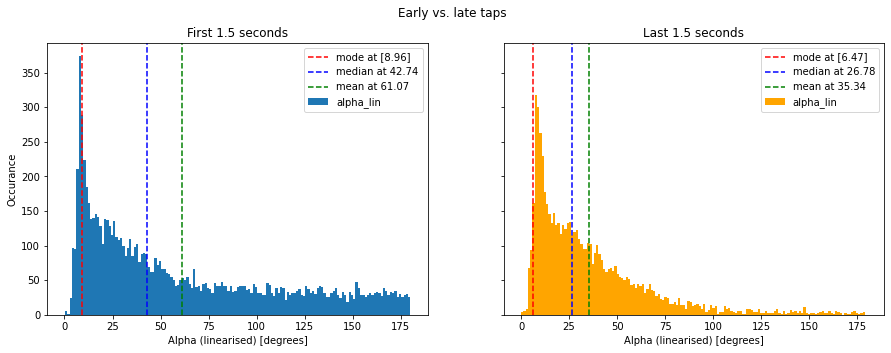

In [22]:
# plot early and late separately
# only use alpha values of correct trials
all_subs = all_subs[all_subs["alpha"] <= 360]

# Plot those alpha values that occur within the range of first tap + 1.5s and last tap - 1.5s (of each trial)
# get data and statistics for first taps
first = all_subs[all_subs["ttap"] <= all_subs.first_tap+1.5 ]
first_mean = np.around(np.mean(first["alpha_lin"]),decimals=2)
first_median = np.around(np.median(first["alpha_lin"]),decimals=2)
first_mode,xyz = stats.mode(np.around(first["alpha_lin"], decimals=2))


# get data and statistics for last taps
last = all_subs[all_subs["ttap"] >= all_subs.last_tap-1.5 ]
last_mean = np.around(np.mean(last["alpha_lin"]),decimals=2)
last_median = np.around(np.median(last["alpha_lin"]),decimals=2)
last_mode,xyz2 = stats.mode(np.around(last["alpha_lin"], decimals=2))


# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharey=True, sharex=True)
plt.suptitle('Early vs. late taps')
first["alpha_lin"].plot.hist(bins=binsize, ax = axes[0])
last["alpha_lin"].plot.hist(bins=binsize, ax = axes[1], color='orange')

axes[0].set_xlabel('Alpha (linearised) [degrees]')
axes[0].set_ylabel("Occurance")
axes[0].set_title("First 1.5 seconds")
axes[1].set_xlabel('Alpha (linearised) [degrees]')
axes[1].set_title("Last 1.5 seconds")


# plot statistics
names = ["mode", "median", "mean"]
colors = ['red', 'blue', 'green']
first_measurement = [first_mode, first_median, first_mean]
last_measurement = [last_mode, last_median, last_mean]


for first_measurement, name, color in zip(first_measurement, names, colors):
    axes[0].axvline(x=first_measurement, linestyle='--', linewidth=1.5, 
                label='{0} at {1}'.format(name, first_measurement), c=color)
axes[0].legend();

for last_measurement, name, color in zip(last_measurement, names, colors):
    axes[1].axvline(x=last_measurement, linestyle='--', linewidth=1.5, 
                label='{0} at {1}'.format(name, last_measurement), c=color)
axes[1].legend();


In [23]:

alpha_level = .05


shap_f, p_f = stats.shapiro(first["alpha_lin"])
shap_l, p_l = stats.shapiro(last["alpha_lin"])


if p_f < alpha_level:
    print(f"Alpha values of first taps are not normal distributed p={p_f}")
else:
    print(f"Alpha values of first taps are not normal distributed p={p_f}")
    
if p_l < alpha_level:
    print(f"Alpha values of last taps are not normal distributed. p={p_l}")
else:
    print(f"Alpha values of last taps are not normal distributed p={p_l}")
    
# Test for difference between first and last taps
#mws, p = stats.mannwhitneyu(first["alpha_lin"],last["alpha_lin"])
#mws,p
#
#if p < alpha_level:
#    print("reject H0")
#else:
#    print("H0 not rejectable")
#    


Alpha values of first taps are not normal distributed p=0.0
Alpha values of last taps are not normal distributed. p=0.0


/net/store/nbp/projects/hyperscanning/study_project/programming_tools/miniconda3/envs/hyperscanning/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [24]:
# get statistics for first alphas
first_stats = np.around(first.groupby(["pair","subject"])["alpha_lin"].agg(['mean','median','std','skew']),decimals=2)
print(np.around(first["alpha_lin"].agg(['mean','median','std','skew']),decimals=2))

first_stats

mean      61.07
median    42.74
std       50.74
skew       0.79
Name: alpha_lin, dtype: float64


mean  median    std  skew
pair subject                            
202  1        61.56   50.98  46.59  0.55
     2        69.48   66.99  51.66  0.43
203  1        59.86   39.99  51.81  0.90
     2        51.79   31.12  49.50  1.21
204  1        50.47   33.37  45.73  1.22
     2        54.34   33.49  48.80  0.99
205  1        52.11   33.85  47.62  1.10
     2        54.56   32.24  53.08  1.10
206  1        57.64   38.27  51.08  0.91
     2        57.90   35.65  52.23  0.98
207  1        64.49   50.78  48.20  0.73
     2        64.10   46.54  50.48  0.77
208  1        77.64   72.16  52.93  0.34
     2        81.76   74.25  56.64  0.22
209  1        57.01   43.35  46.63  0.76
     2        58.06   42.87  48.60  0.82
211  1        49.85   30.10  46.35  1.02
     2        52.30   37.04  45.28  0.83
212  1        62.28   50.82  45.63  0.75
     2        77.08   66.53  54.39  0.34

In [25]:
# get statistics for last alphas
last_stats = np.around(last.groupby(["pair","subject"])["alpha_lin"].agg(['mean','median','std','skew']),decimals=2)
print(np.around(last["alpha_lin"].agg(['mean','median','std','skew']),decimals=2))
last_stats

mean      35.34
median    26.78
std       30.22
skew       1.83
Name: alpha_lin, dtype: float64


mean  median    std  skew
pair subject                            
202  1        23.67   16.86  25.99  3.11
     2        21.73   17.00  16.83  1.54
203  1        25.64   21.22  19.77  2.05
     2        23.91   17.74  19.89  2.36
204  1        31.97   28.47  21.59  0.98
     2        32.60   26.78  22.71  0.88
205  1        27.38   22.13  19.53  1.45
     2        27.58   22.02  20.49  1.42
206  1        32.45   25.37  26.02  1.65
     2        34.19   28.08  27.36  2.05
207  1        48.67   37.98  38.87  1.33
     2        45.86   35.17  36.08  1.38
208  1        56.22   49.72  38.89  1.09
     2        55.42   47.92  38.20  1.00
209  1        22.43   18.72  15.63  1.12
     2        25.22   19.47  22.47  2.70
211  1        22.27   17.90  17.40  1.50
     2        22.42   19.48  16.13  1.88
212  1        43.96   34.37  35.14  1.36
     2        41.56   31.54  34.12  1.63

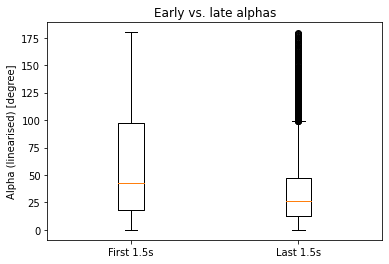

In [26]:
# boxplot of early vs late
plt.boxplot([all_subs[all_subs["ttap"] <= all_subs.first_tap+1.5 ]["alpha_lin"],
             all_subs[all_subs["ttap"] >= all_subs.last_tap-1.5 ]["alpha_lin"]])

plt.title("Early vs. late alphas")
plt.ylabel("Alpha (linearised) [degree]")
plt.xticks(ticks=np.arange(1,3),labels=["First 1.5s","Last 1.5s"])

# create fig object
boxplot_early_vs_late = plt.gcf()
# save fig object
#pickle.dump(boxplot_early_vs_late, open(behav_plots + "boxplot_early_vs_late.p", 'wb'))

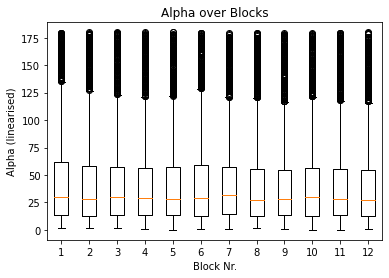

In [27]:
# Alpha over blocks
plt.boxplot([all_subs[all_subs["block"]==1]["alpha_lin"],
             all_subs[all_subs["block"]==2]["alpha_lin"],
             all_subs[all_subs["block"]==3]["alpha_lin"],
             all_subs[all_subs["block"]==4]["alpha_lin"],
             all_subs[all_subs["block"]==5]["alpha_lin"],
             all_subs[all_subs["block"]==6]["alpha_lin"],
             all_subs[all_subs["block"]==7]["alpha_lin"],
             all_subs[all_subs["block"]==8]["alpha_lin"],
             all_subs[all_subs["block"]==9]["alpha_lin"],
             all_subs[all_subs["block"]==10]["alpha_lin"],
             all_subs[all_subs["block"]==11]["alpha_lin"],
             all_subs[all_subs["block"]==12]["alpha_lin"]]
            )
plt.title("Alpha over Blocks")
plt.ylabel("Alpha (linearised)")
plt.xlabel("Block Nr.")
plt.xticks(ticks=np.arange(1,13),labels=range(1,13))


# create fig object
boxplot_blocks = plt.gcf()
# save fig object
#pickle.dump(boxplot_blocks, open(behav_plots + "boxplot_blocks.p", 'wb'))

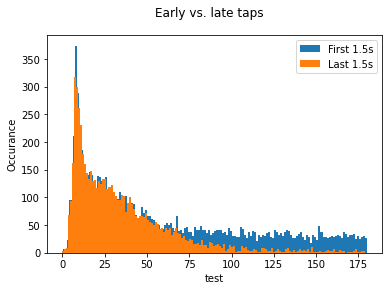

In [29]:

early_vs_late_taps.axes[0].set_xlabel('test')
early_vs_late_taps


# Pairwise

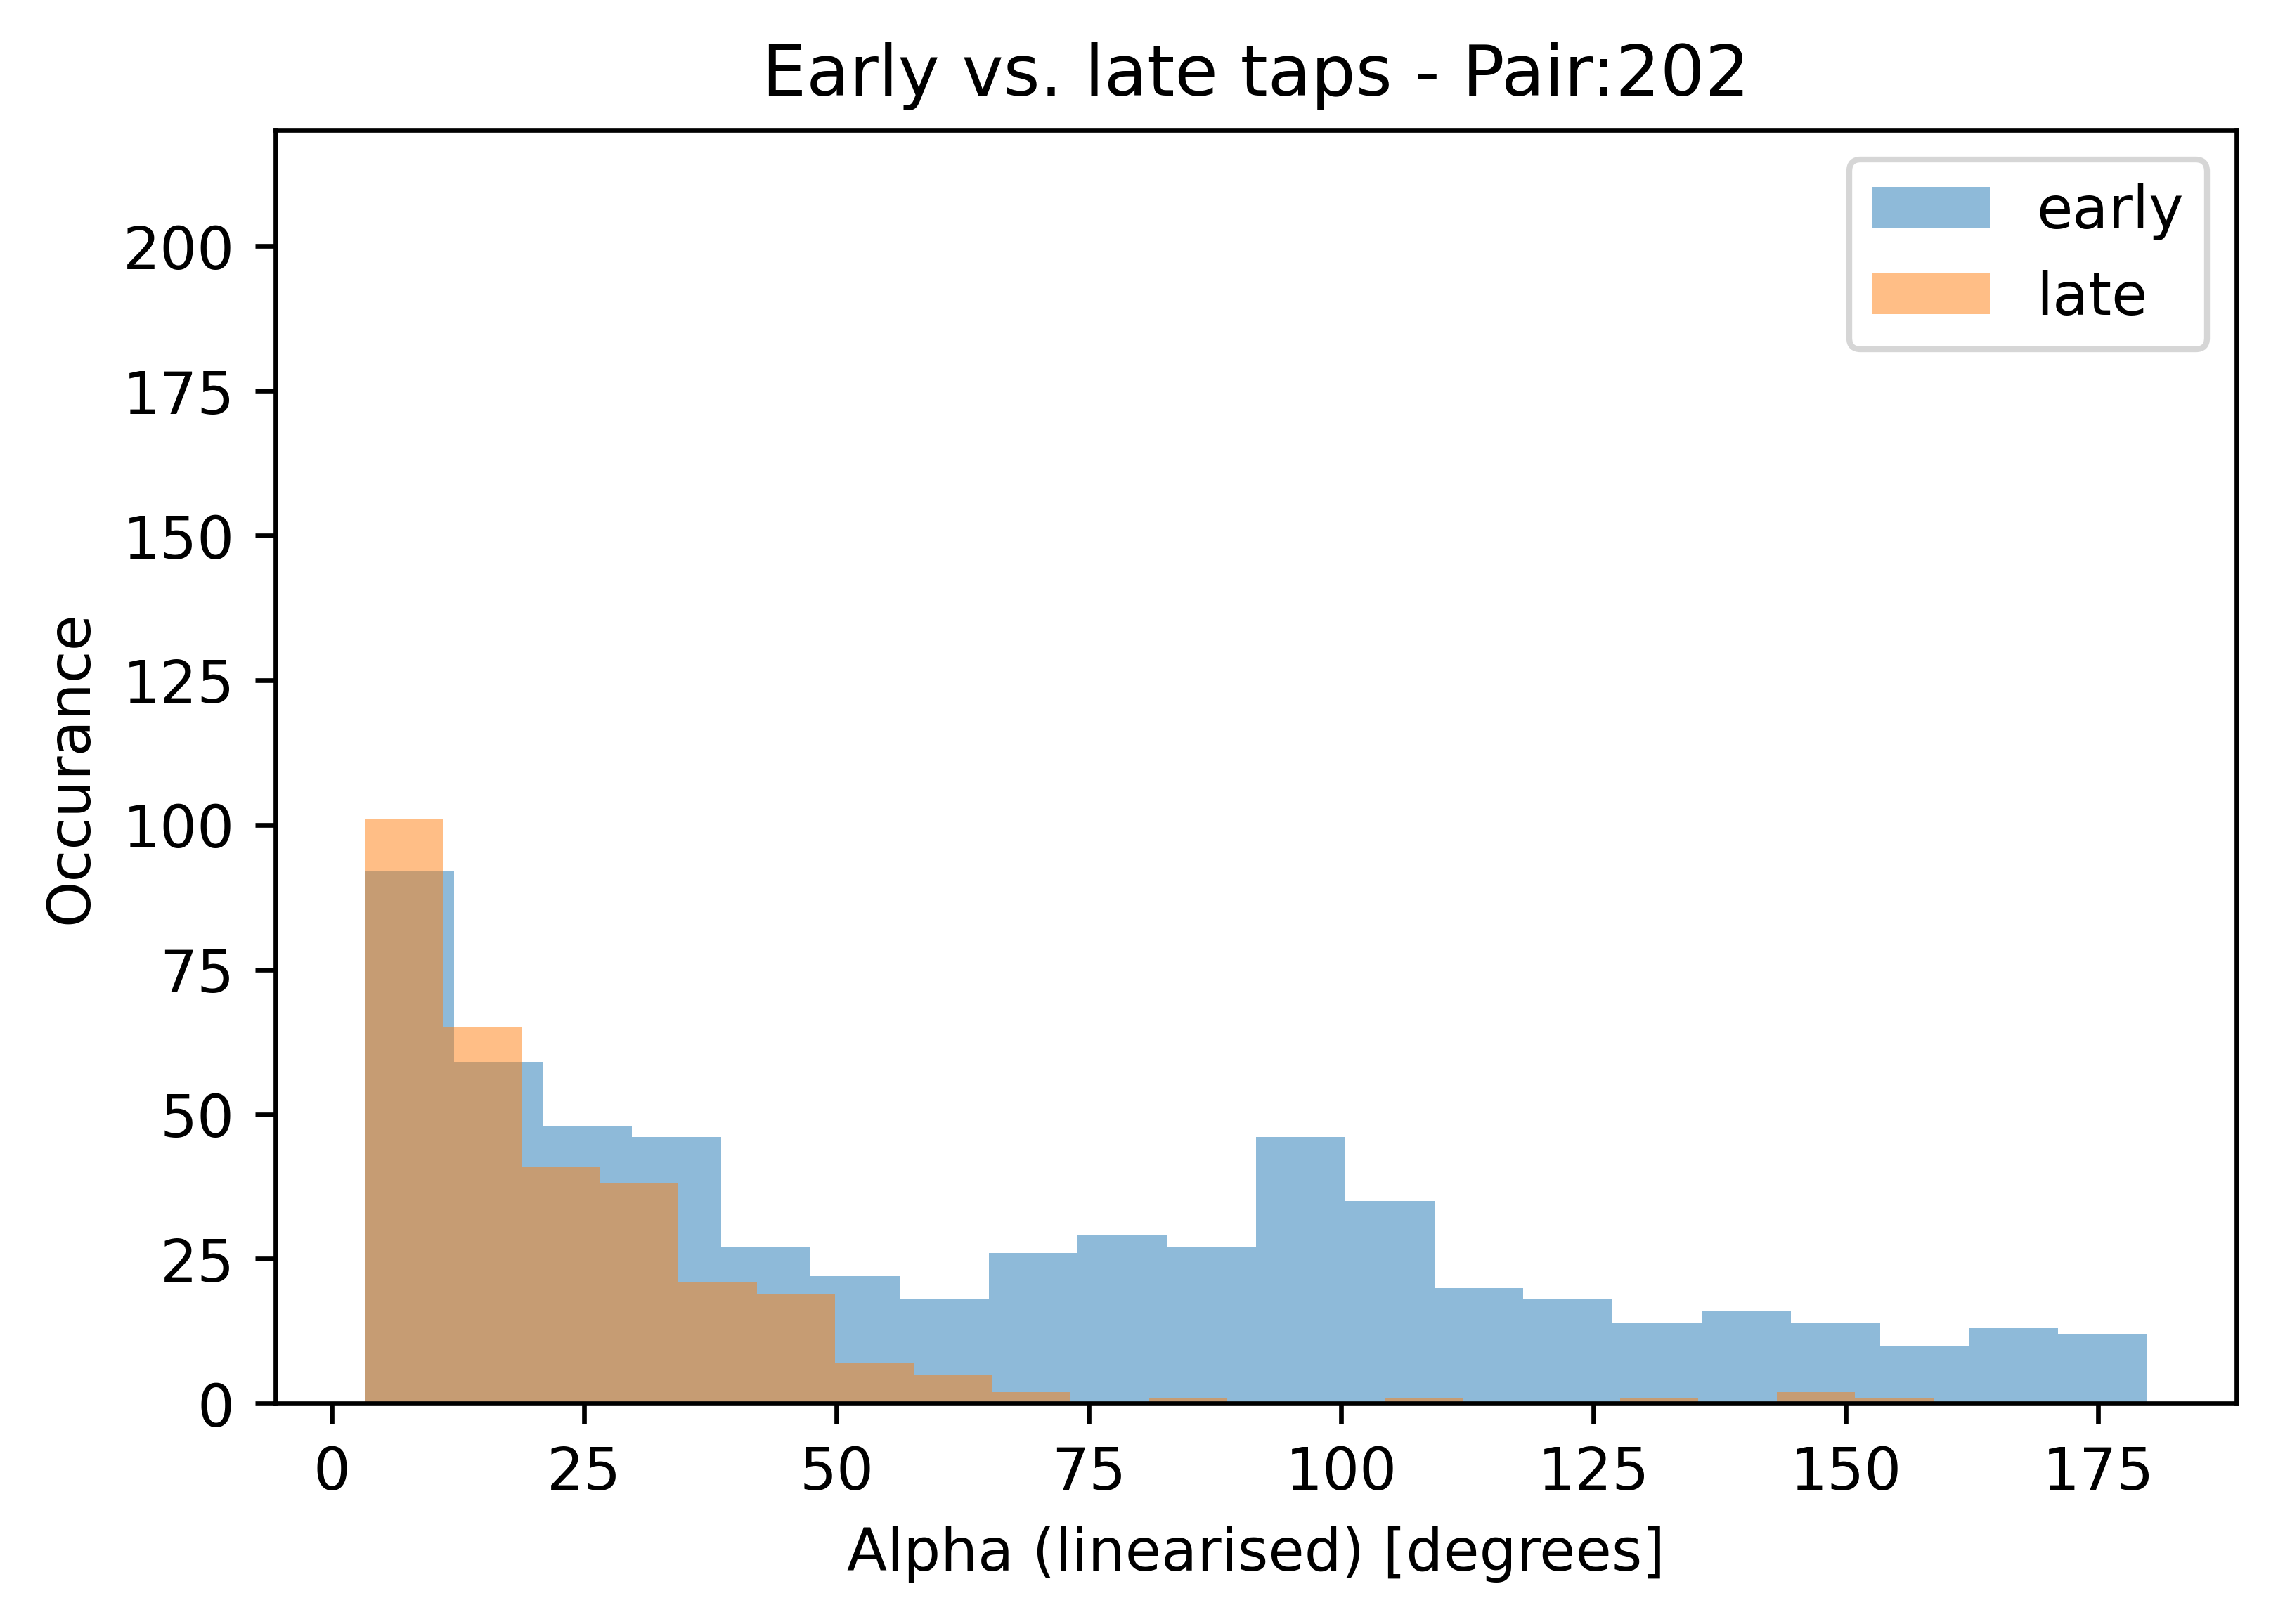

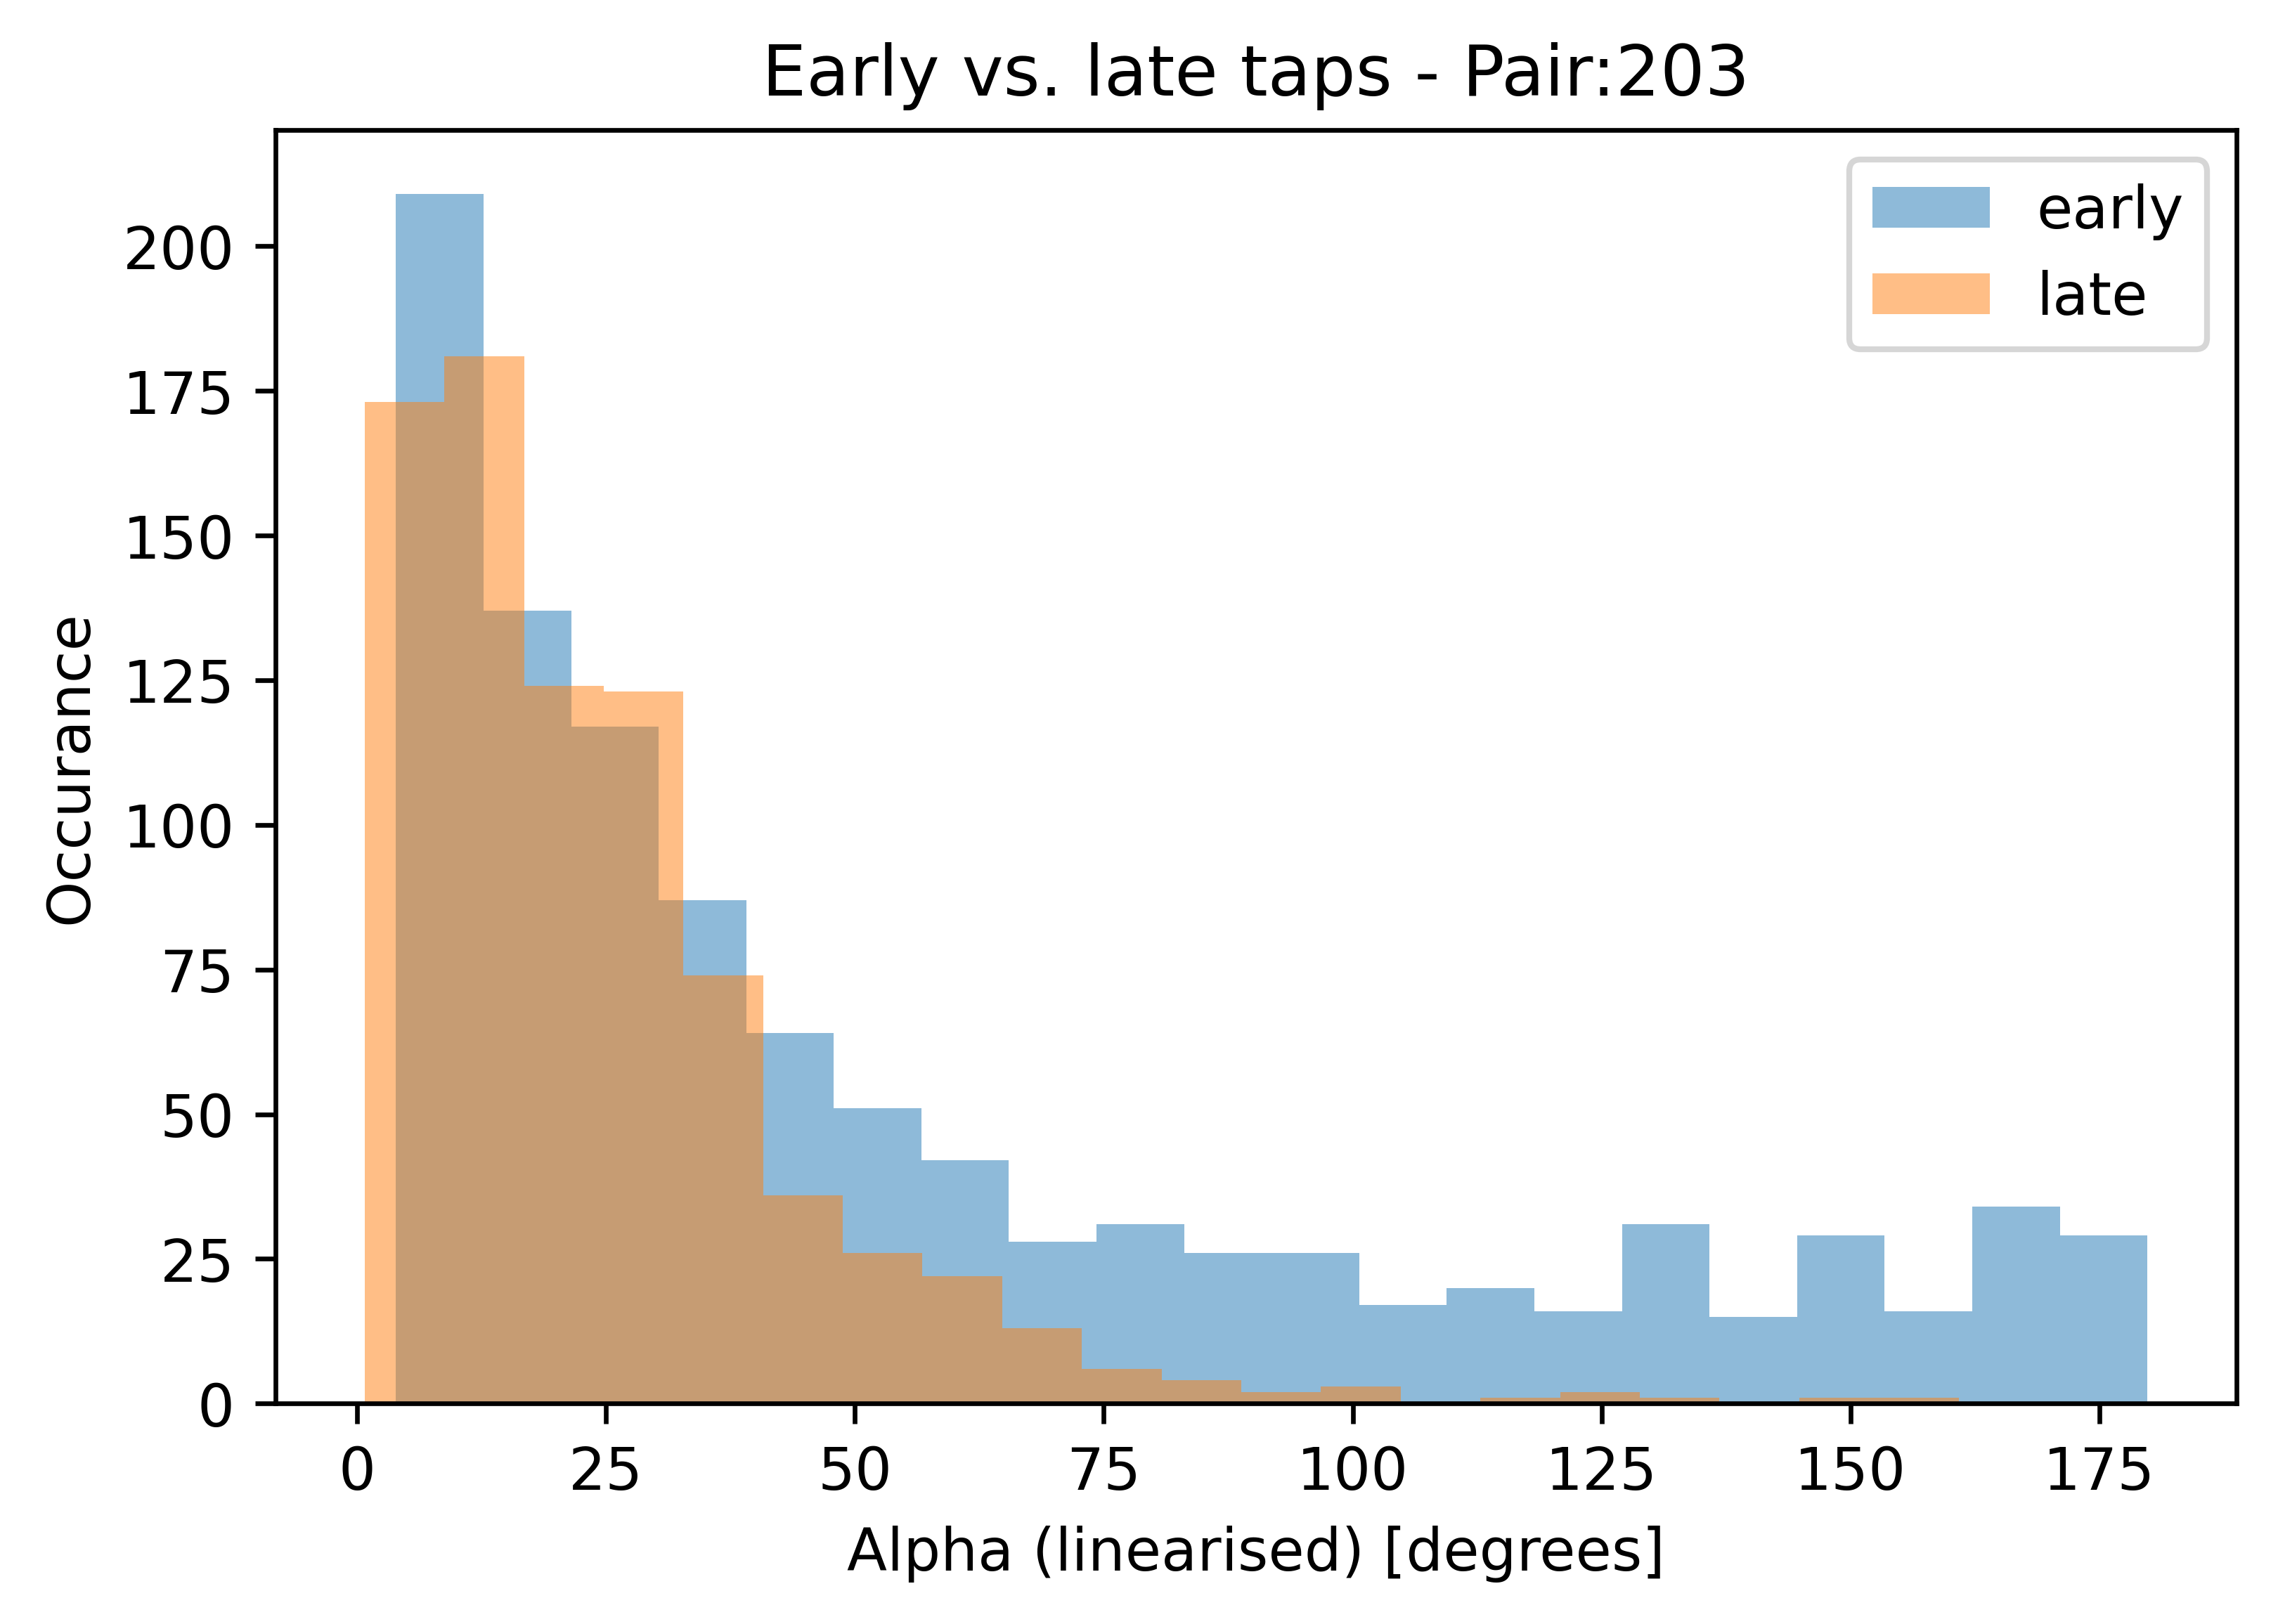

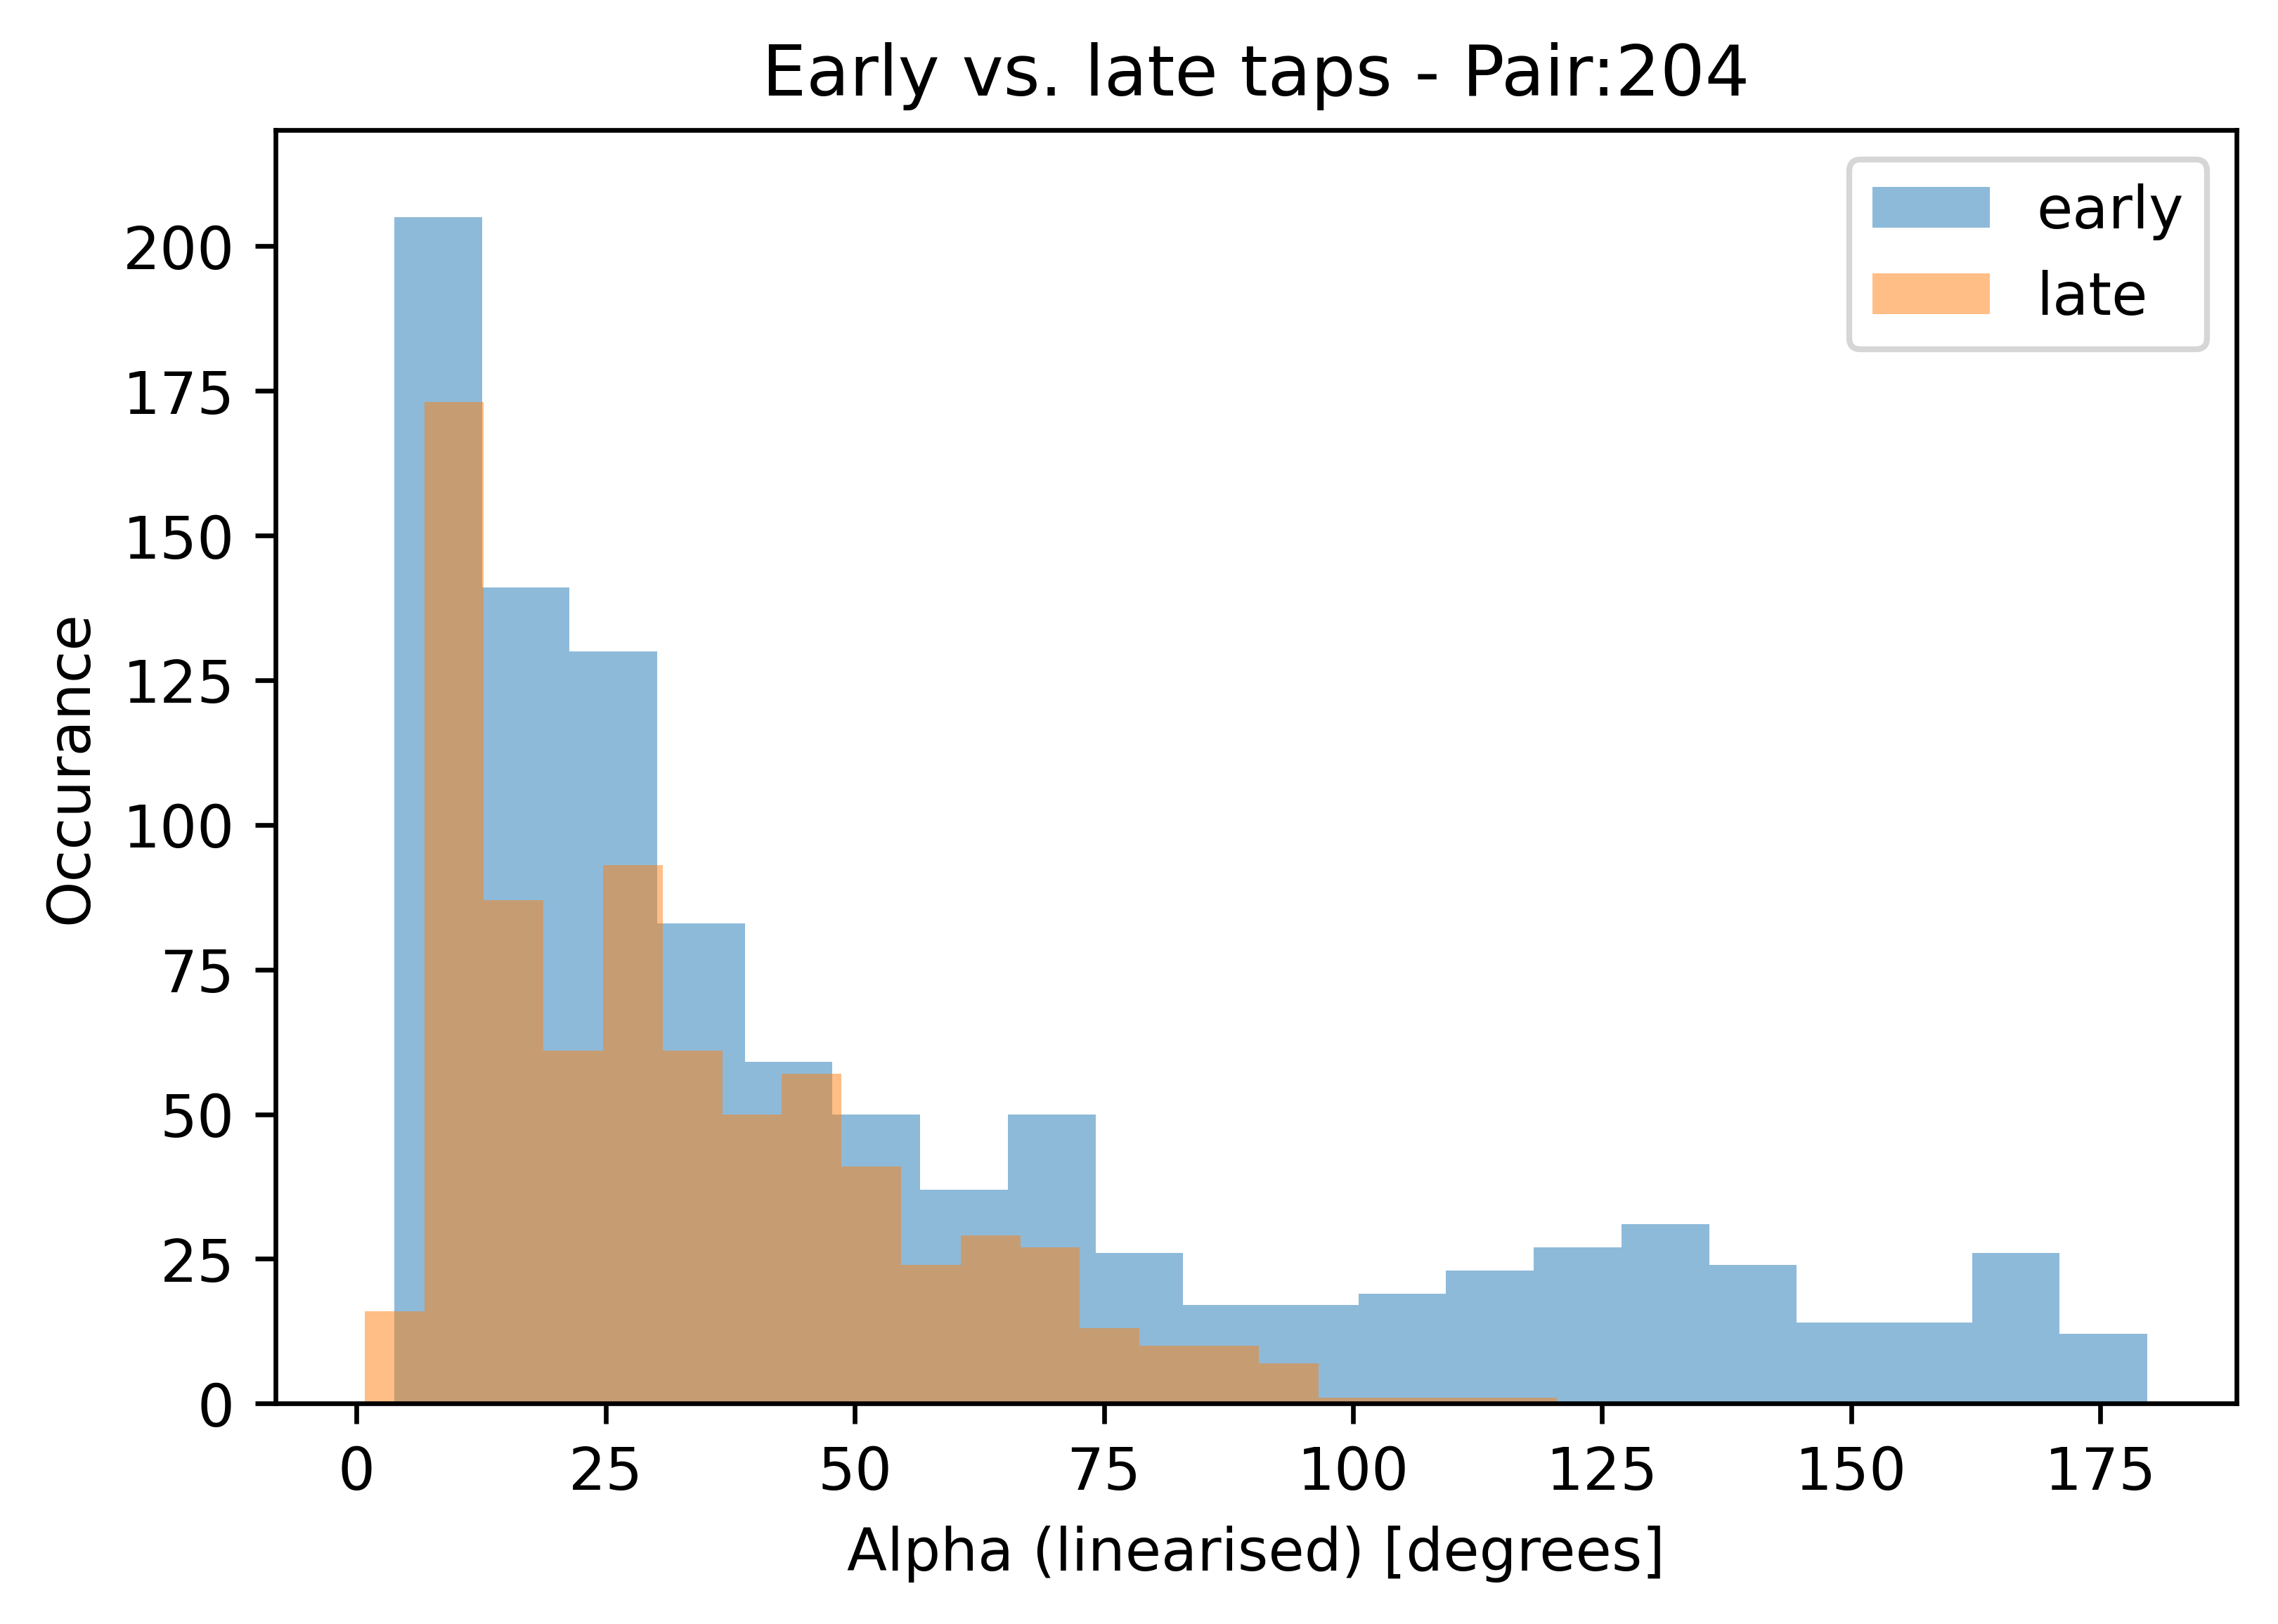

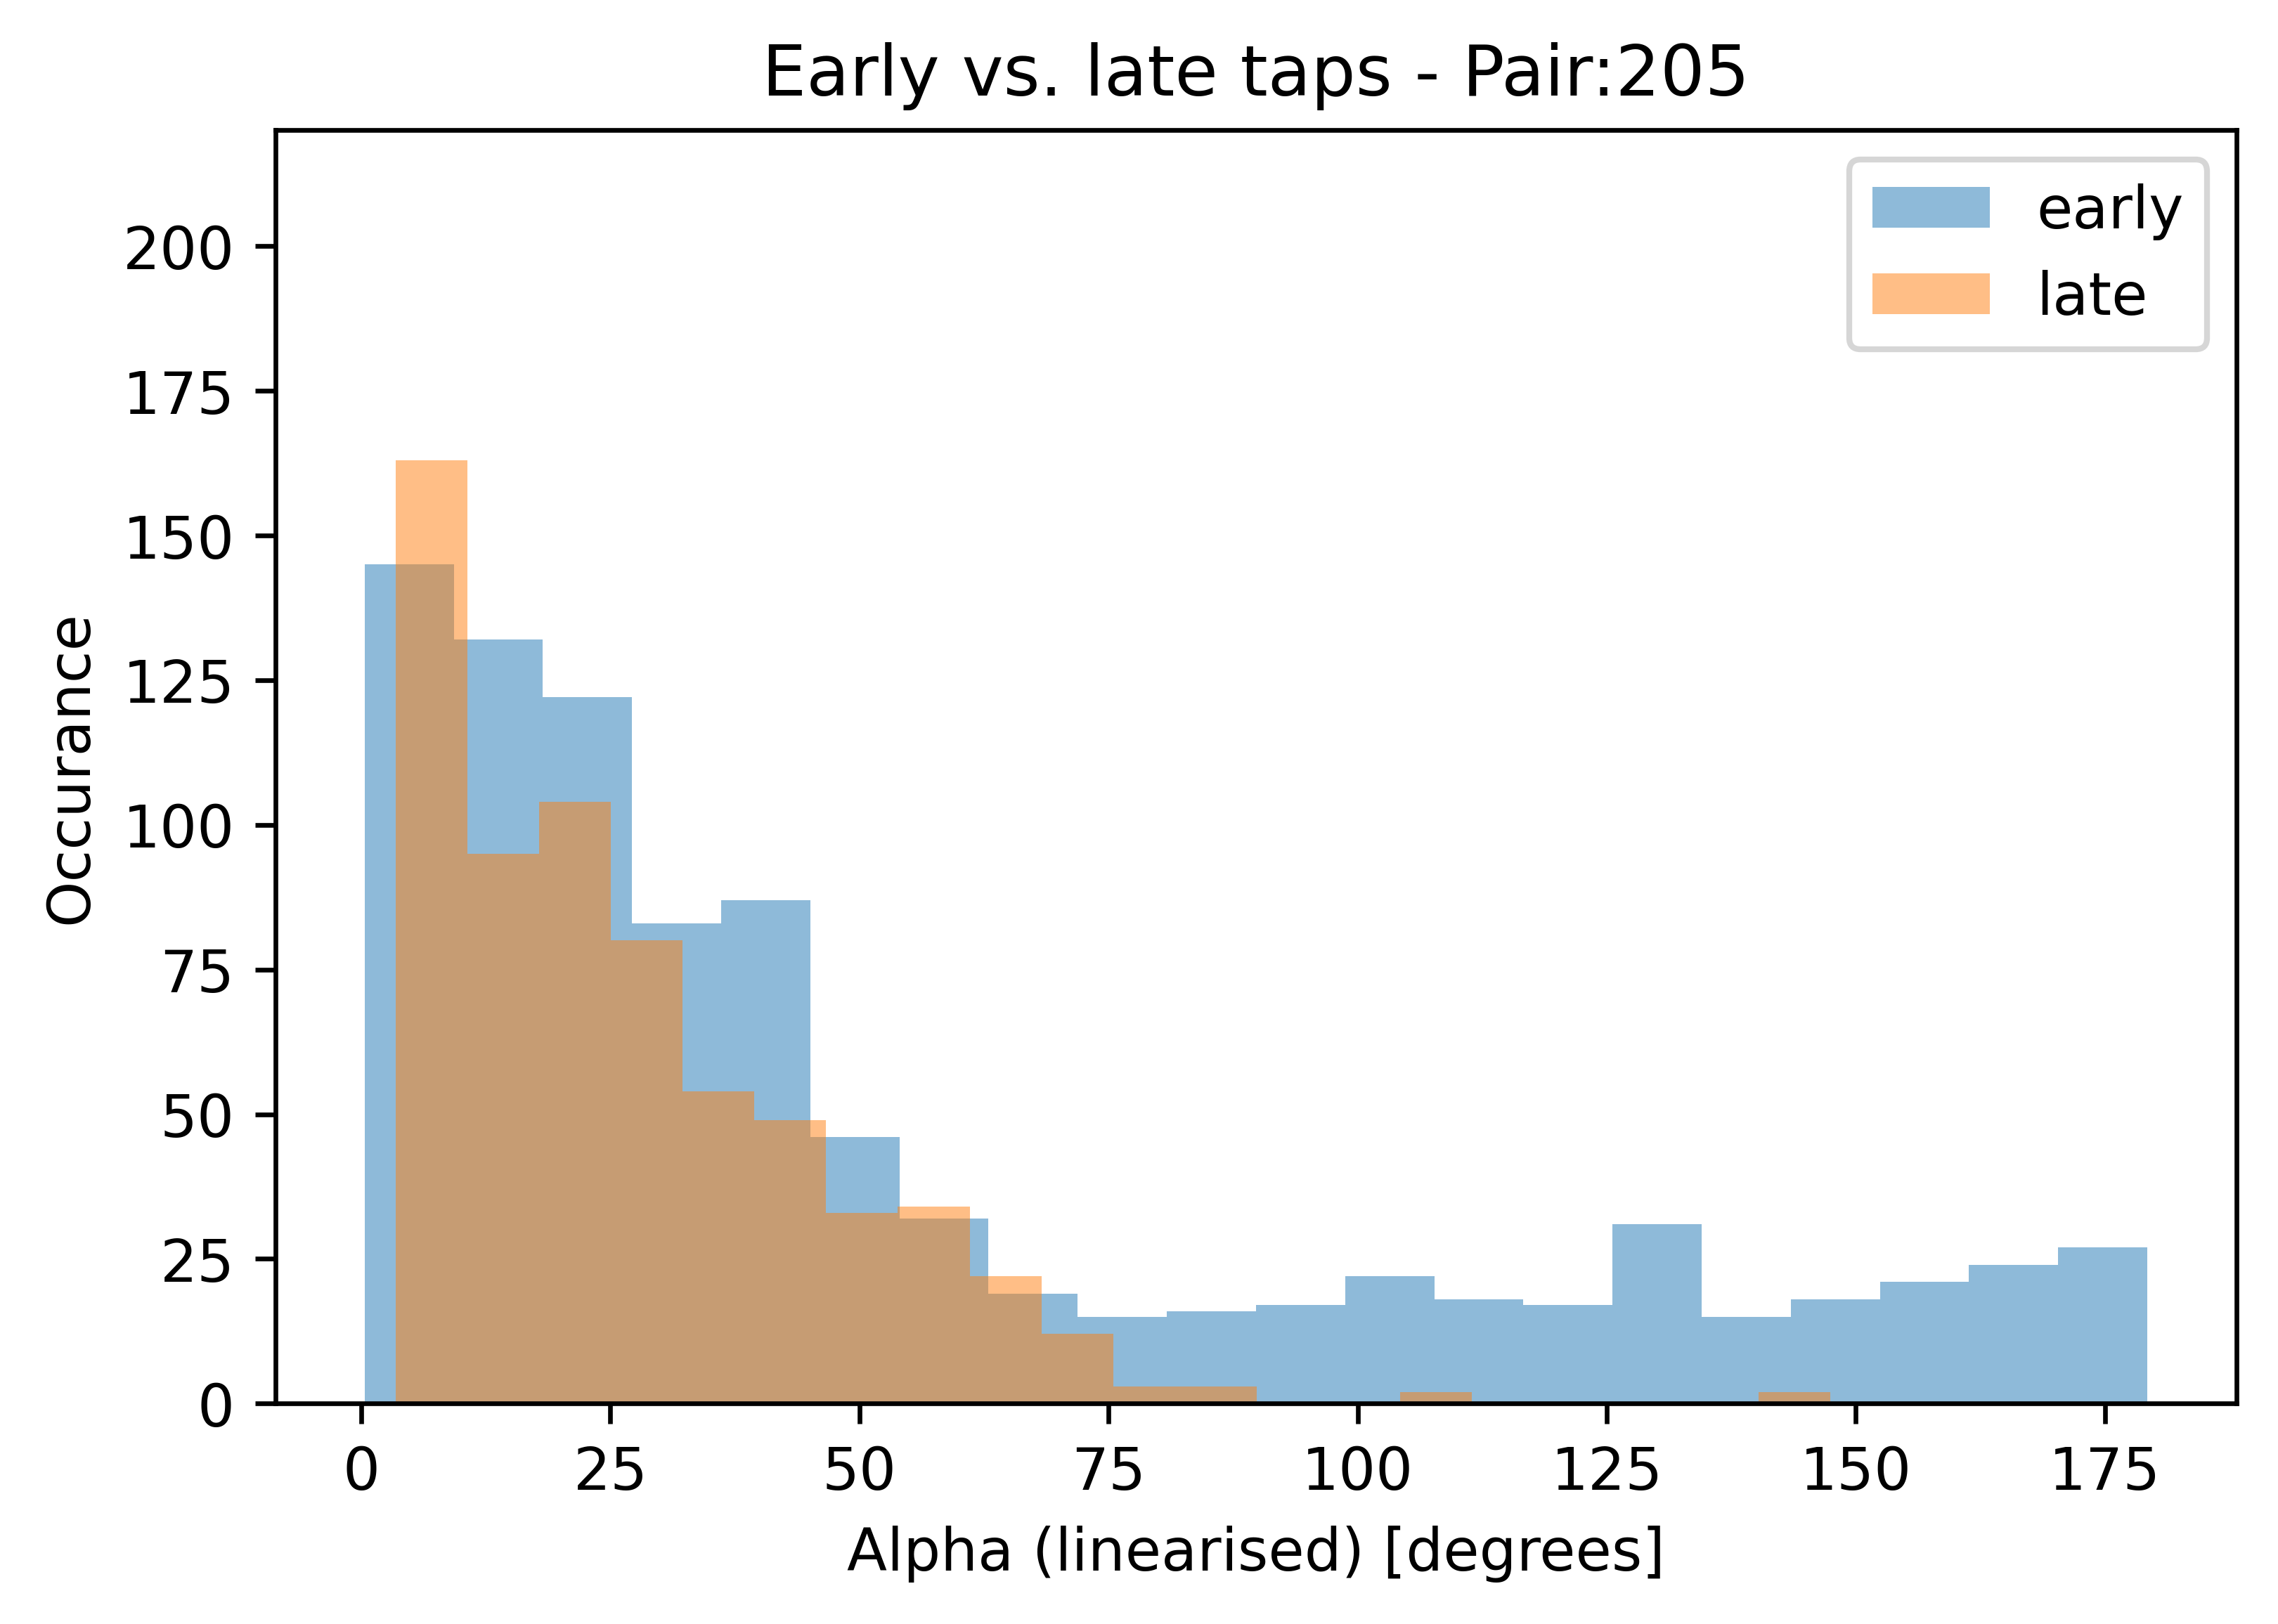

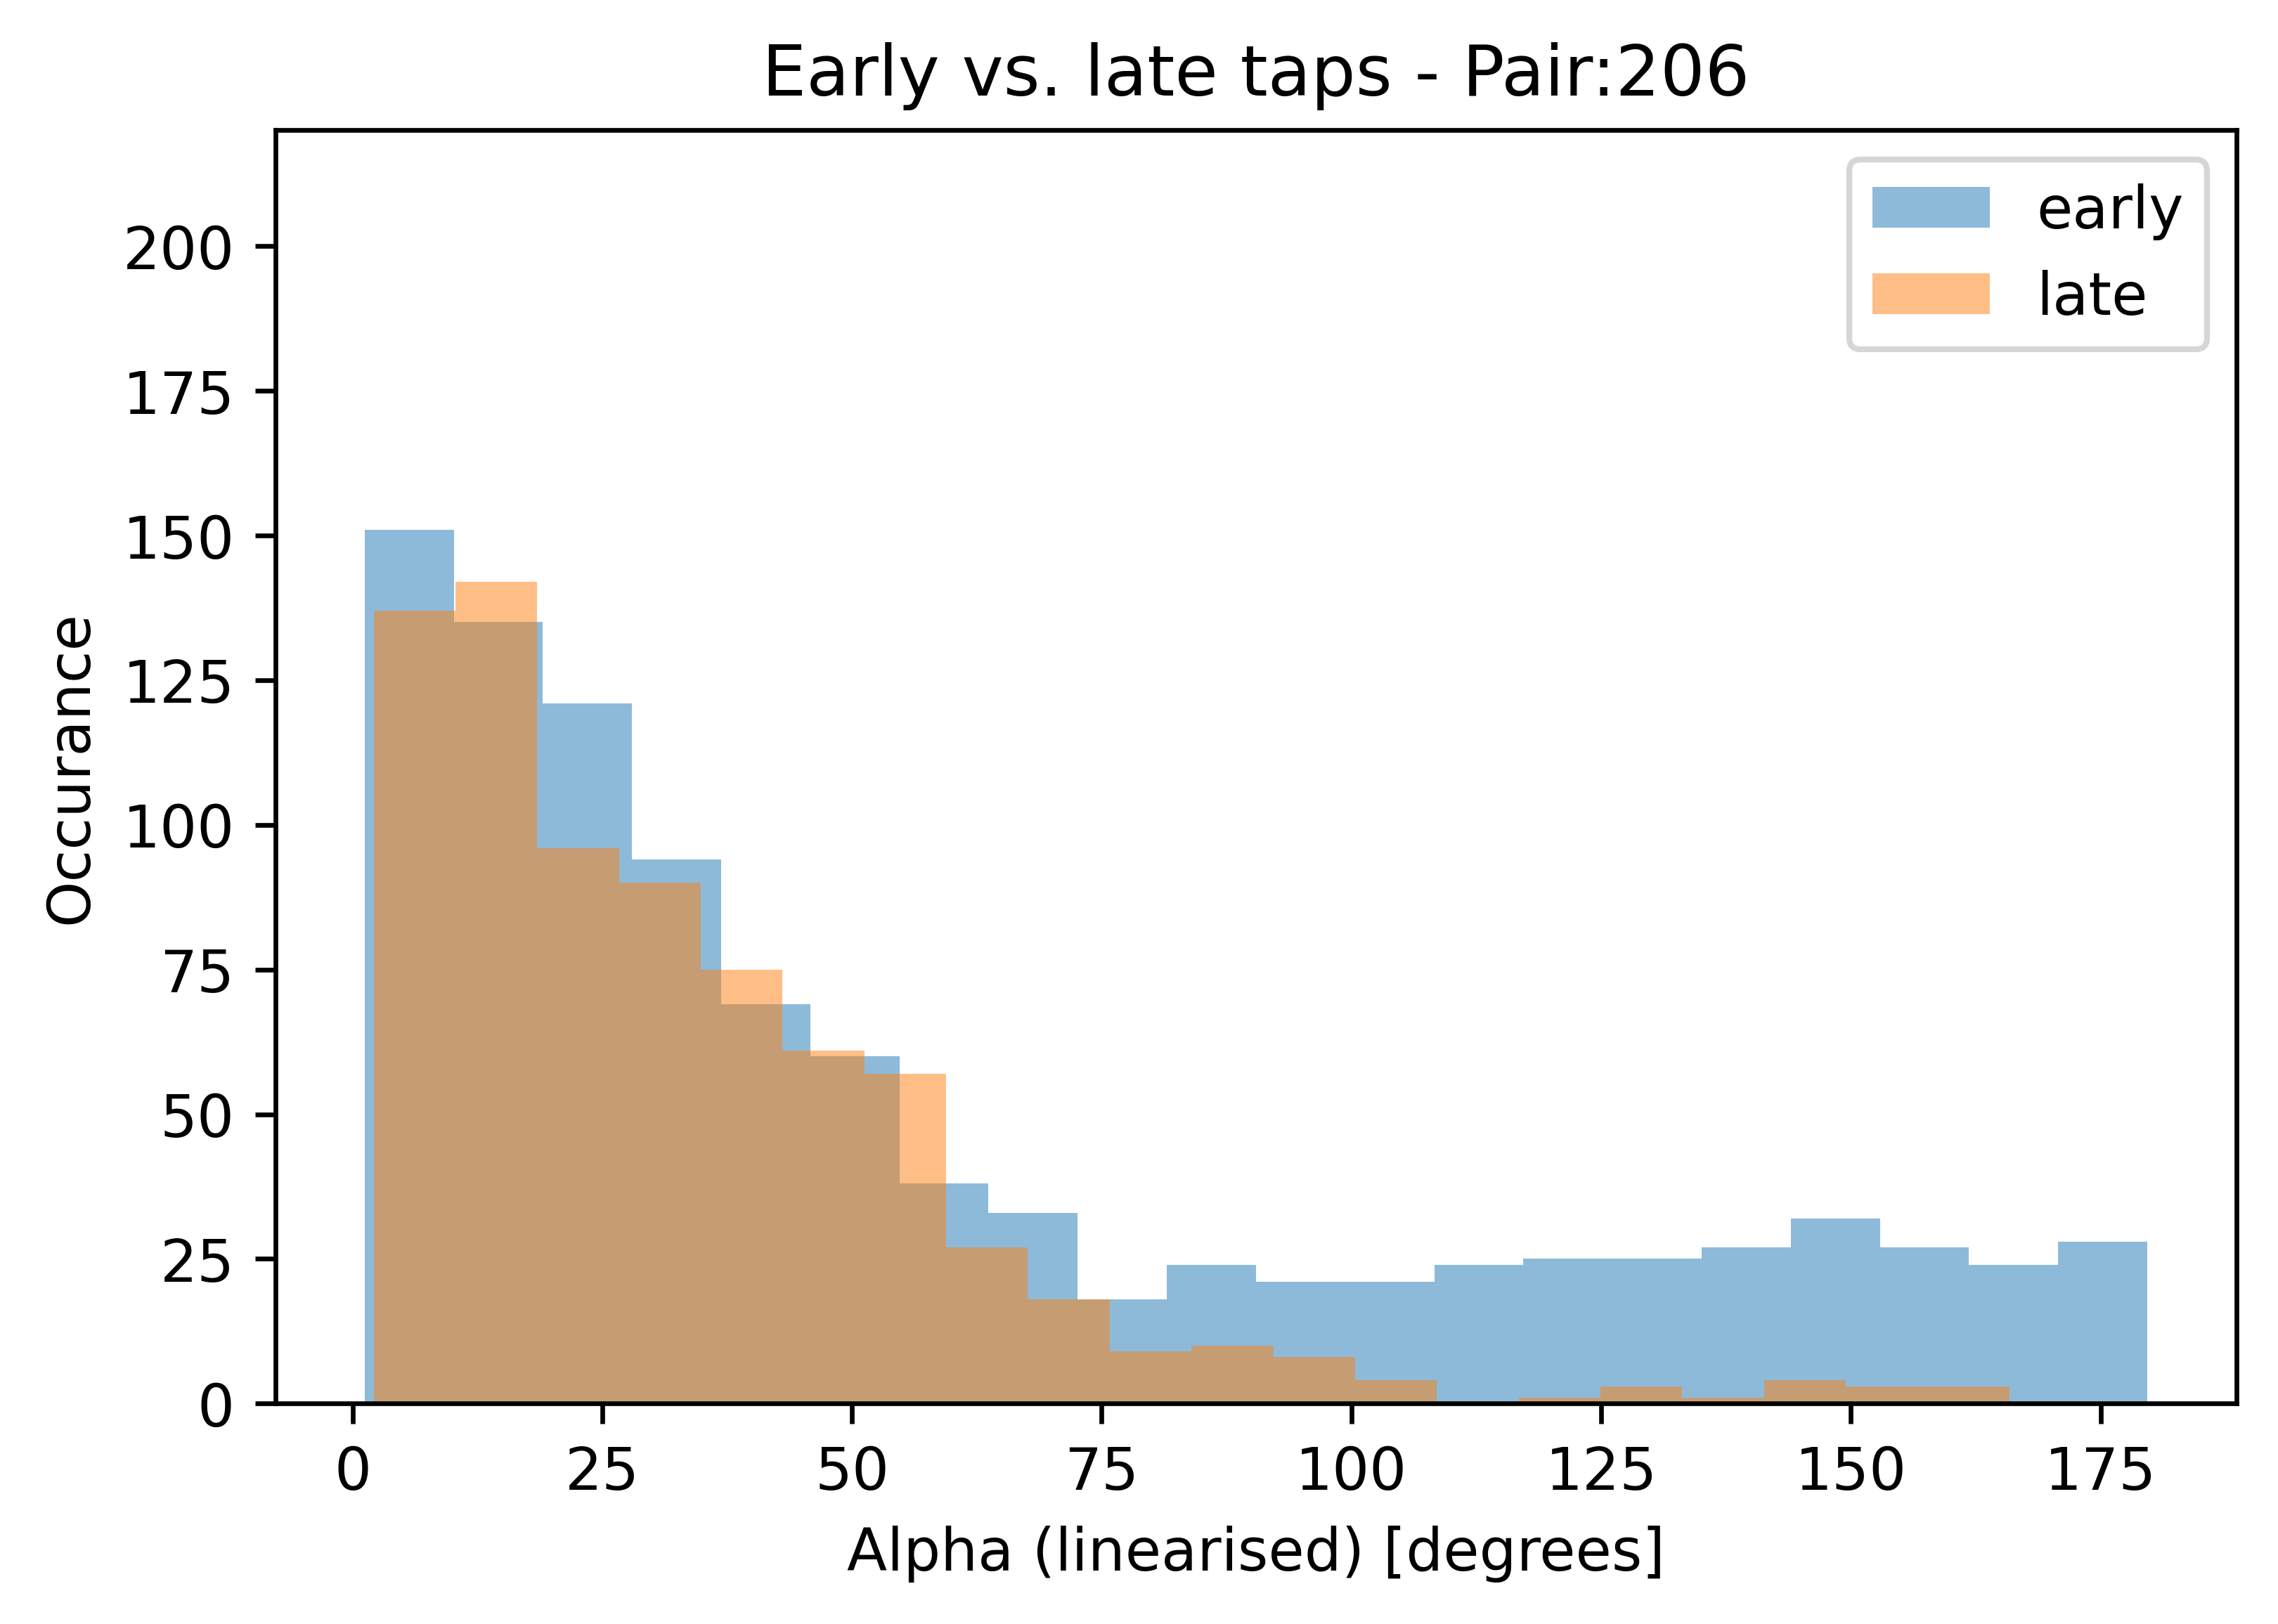

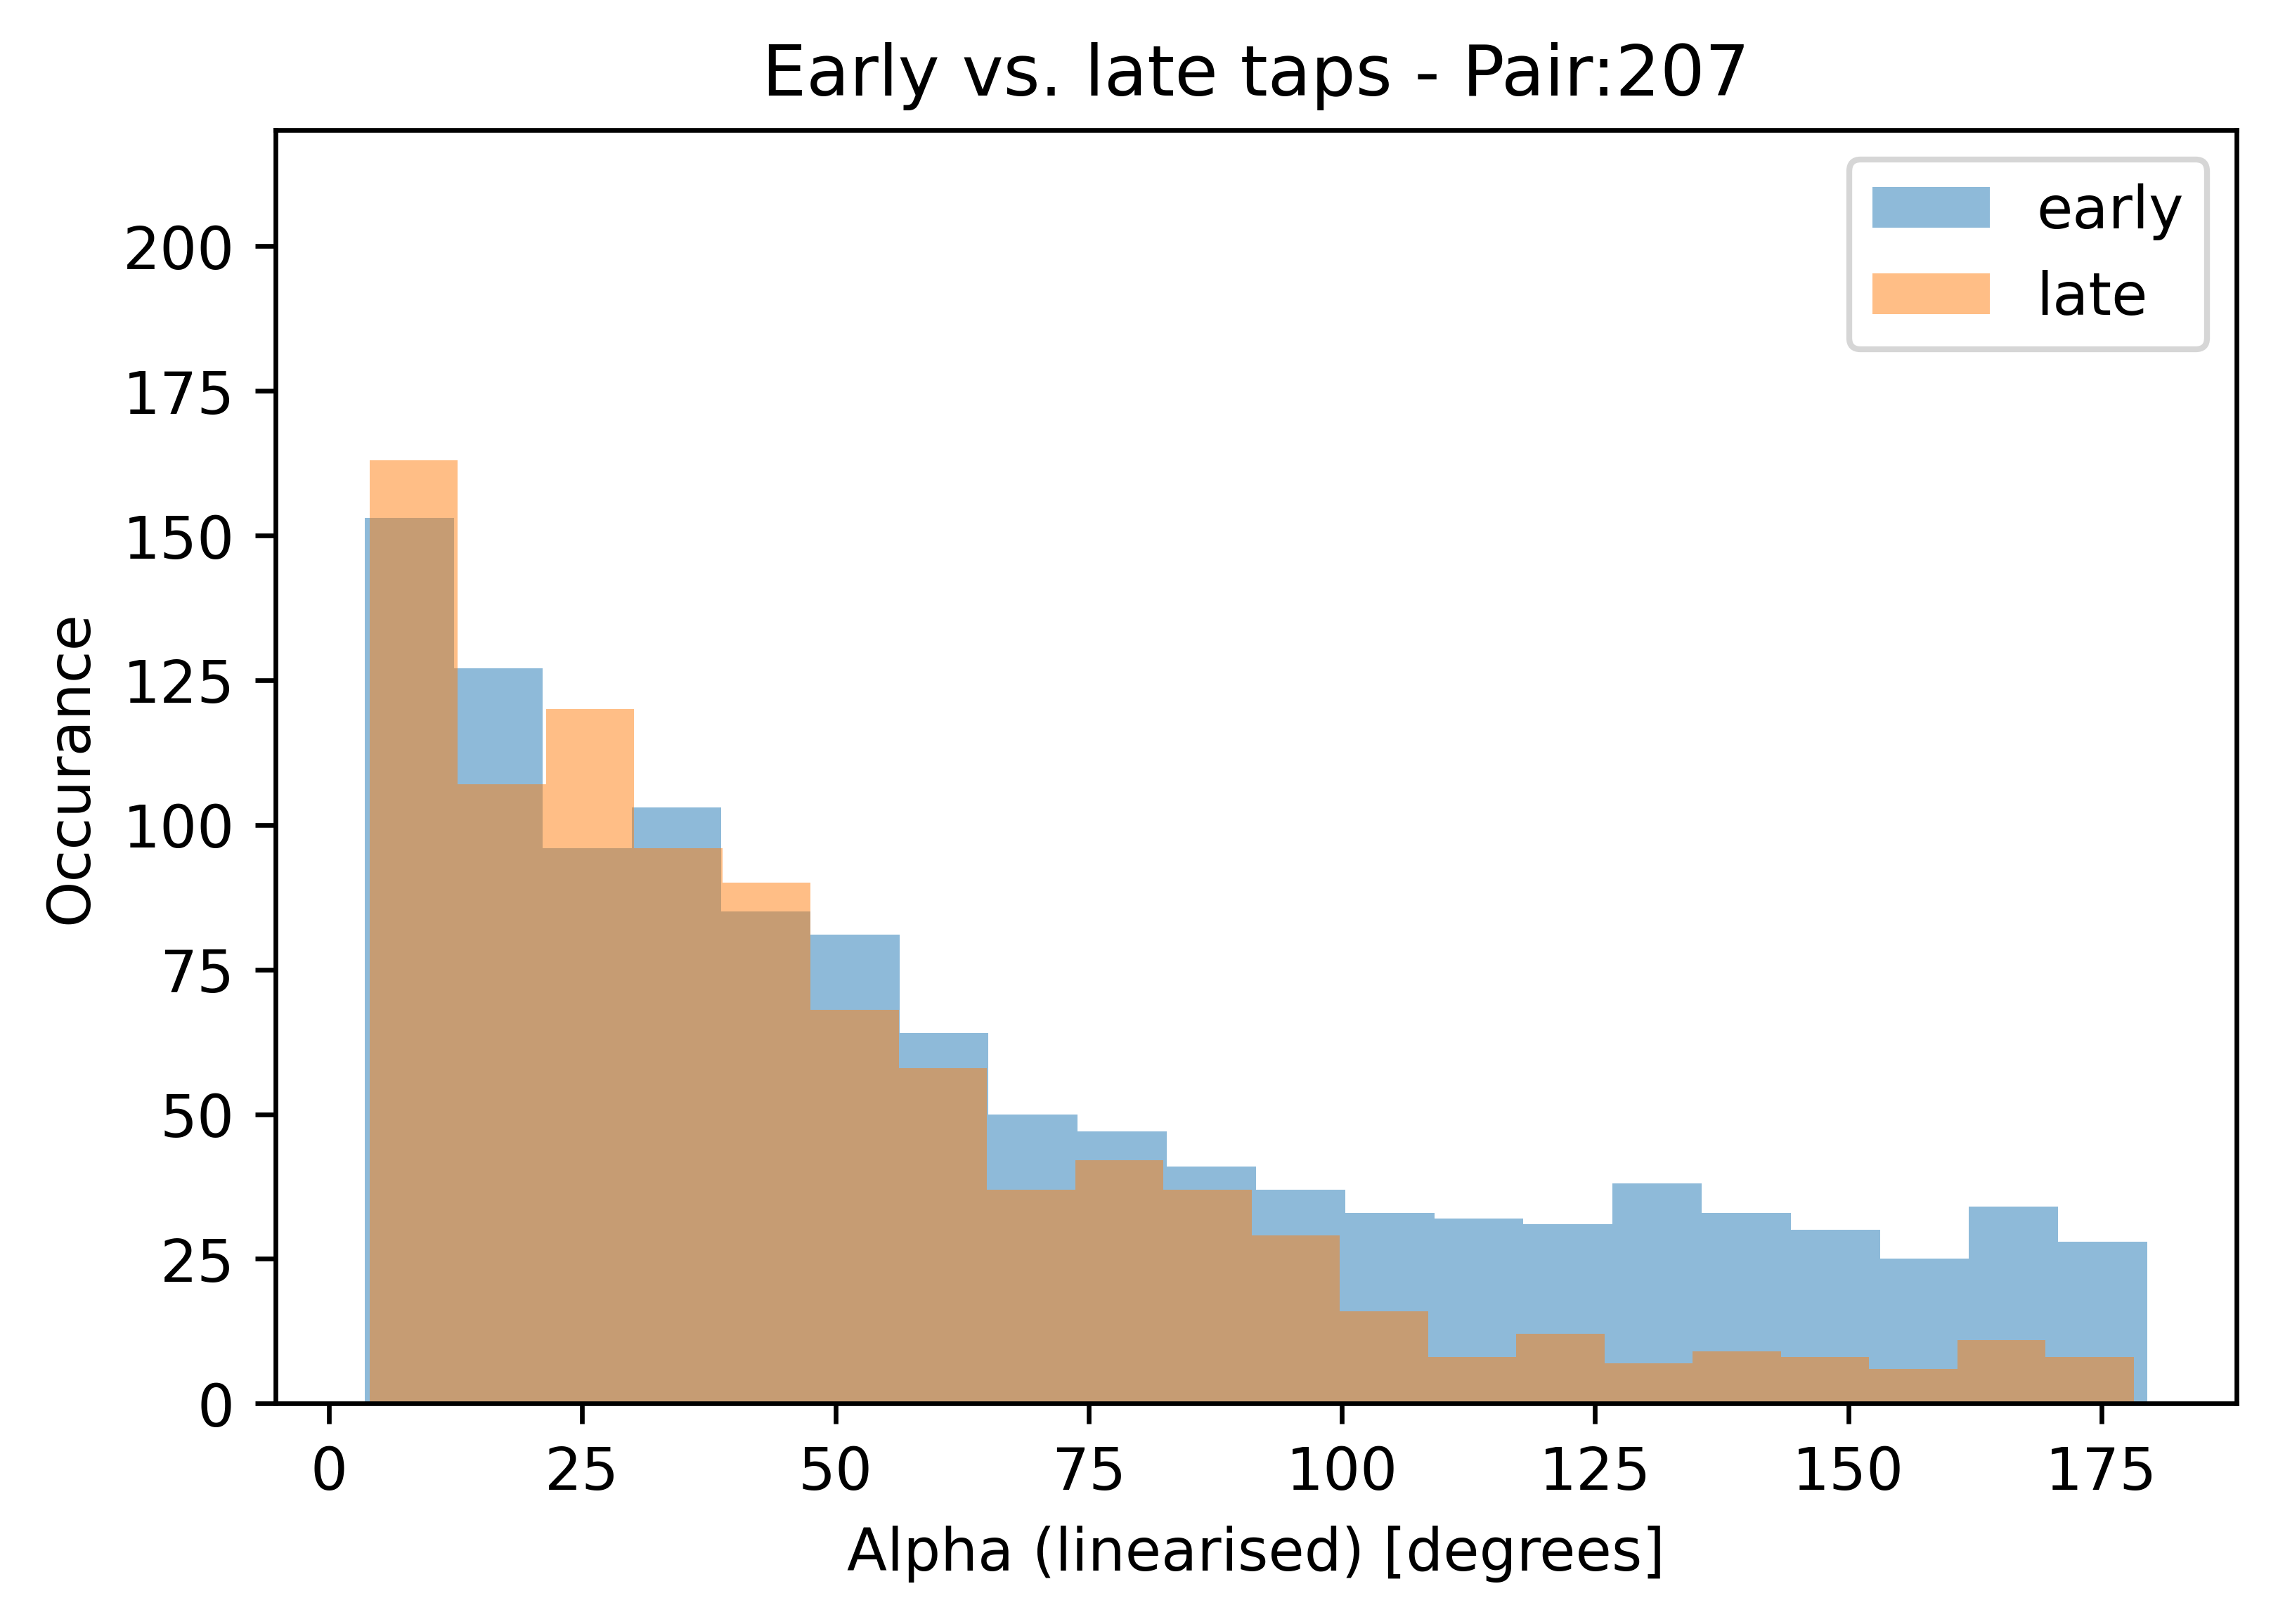

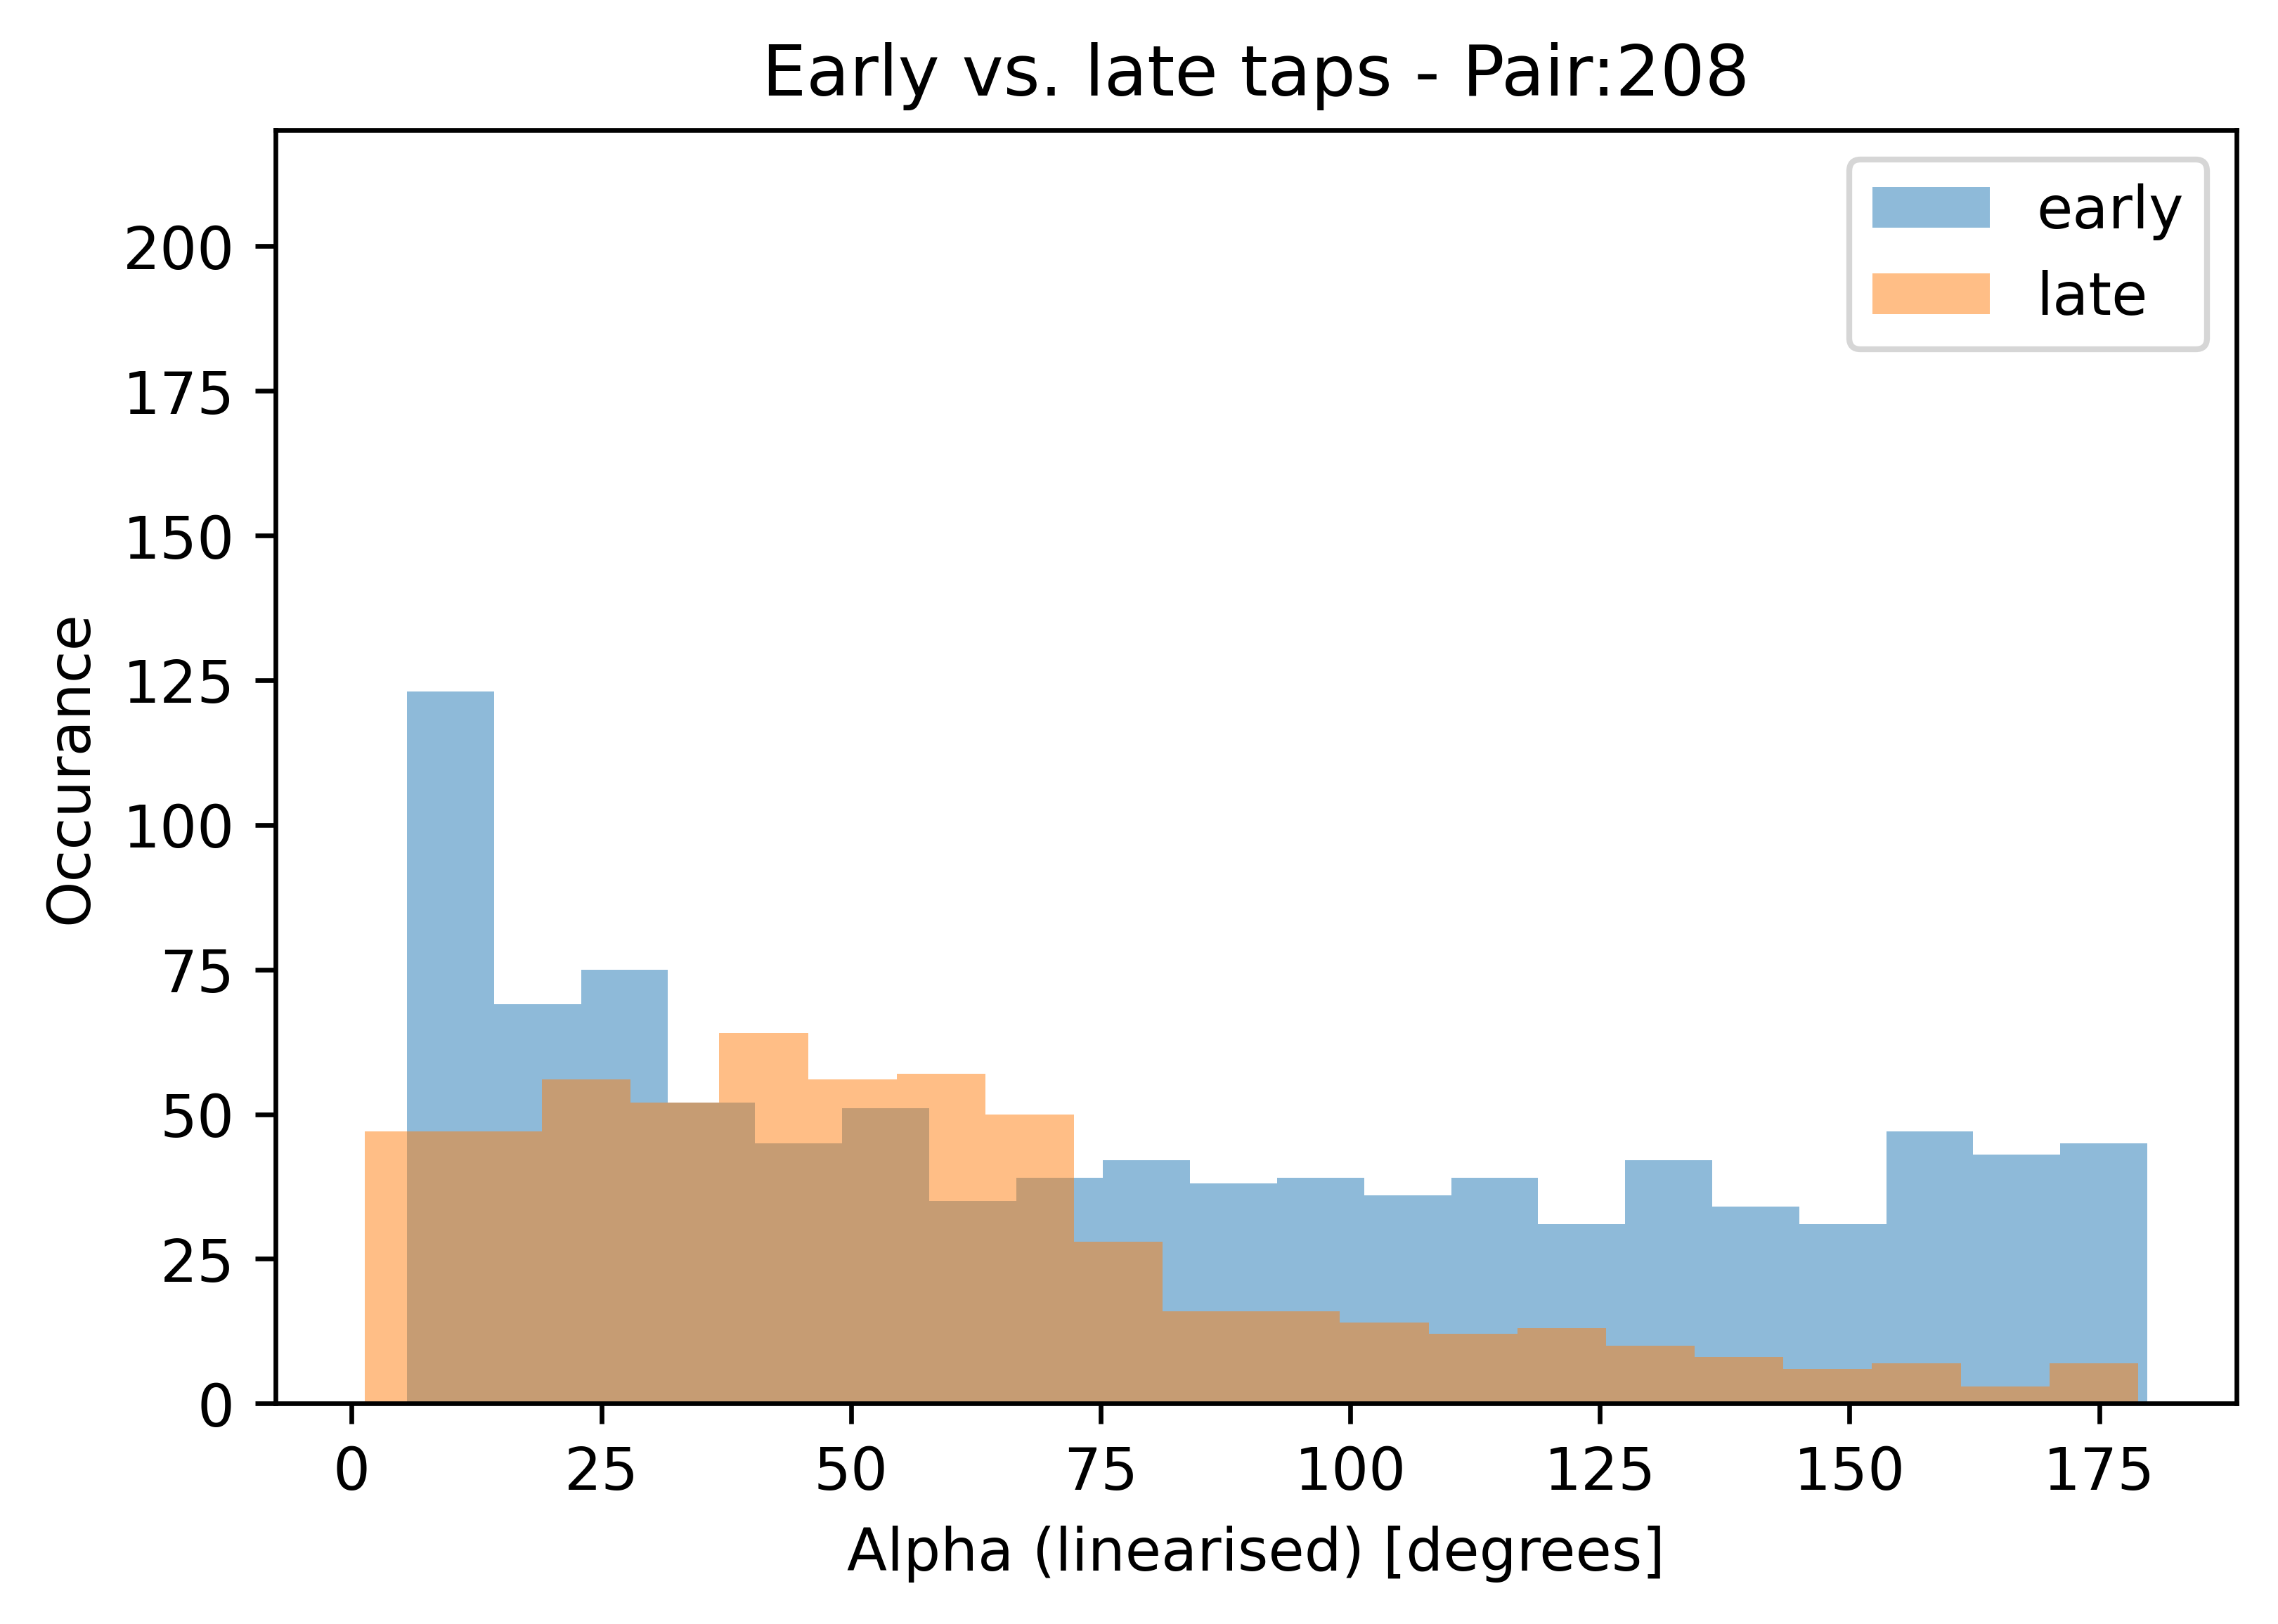

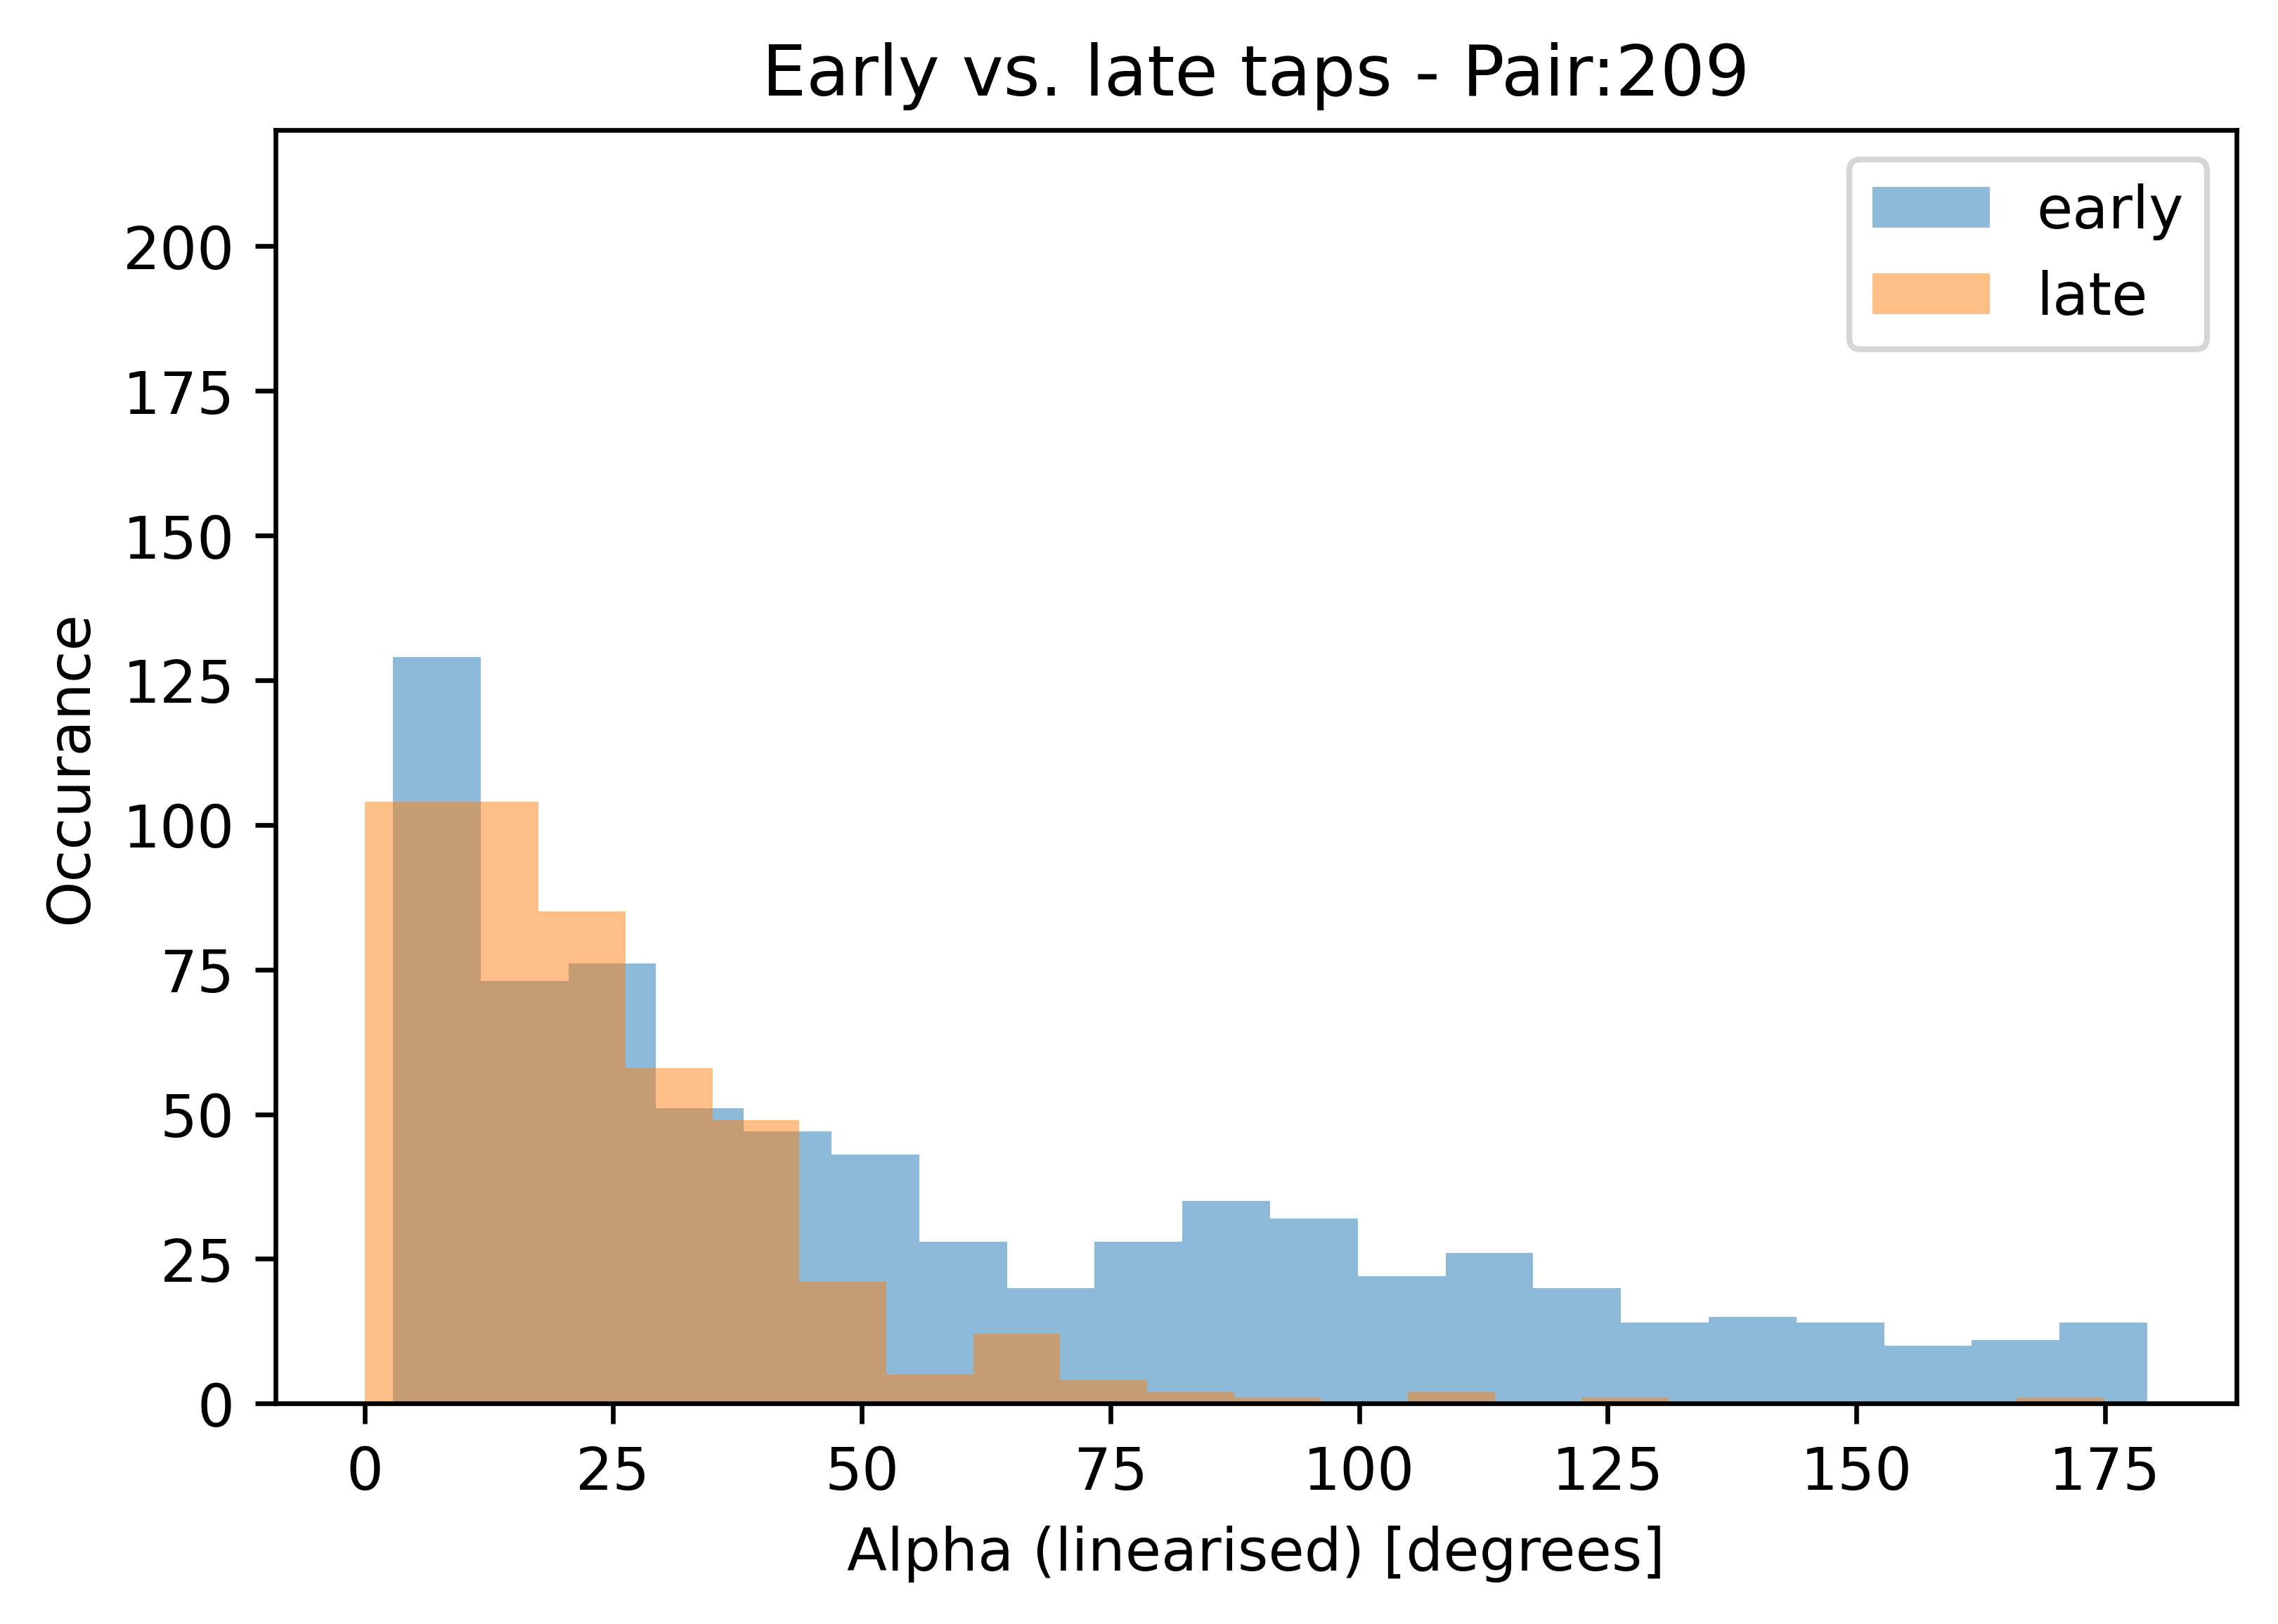

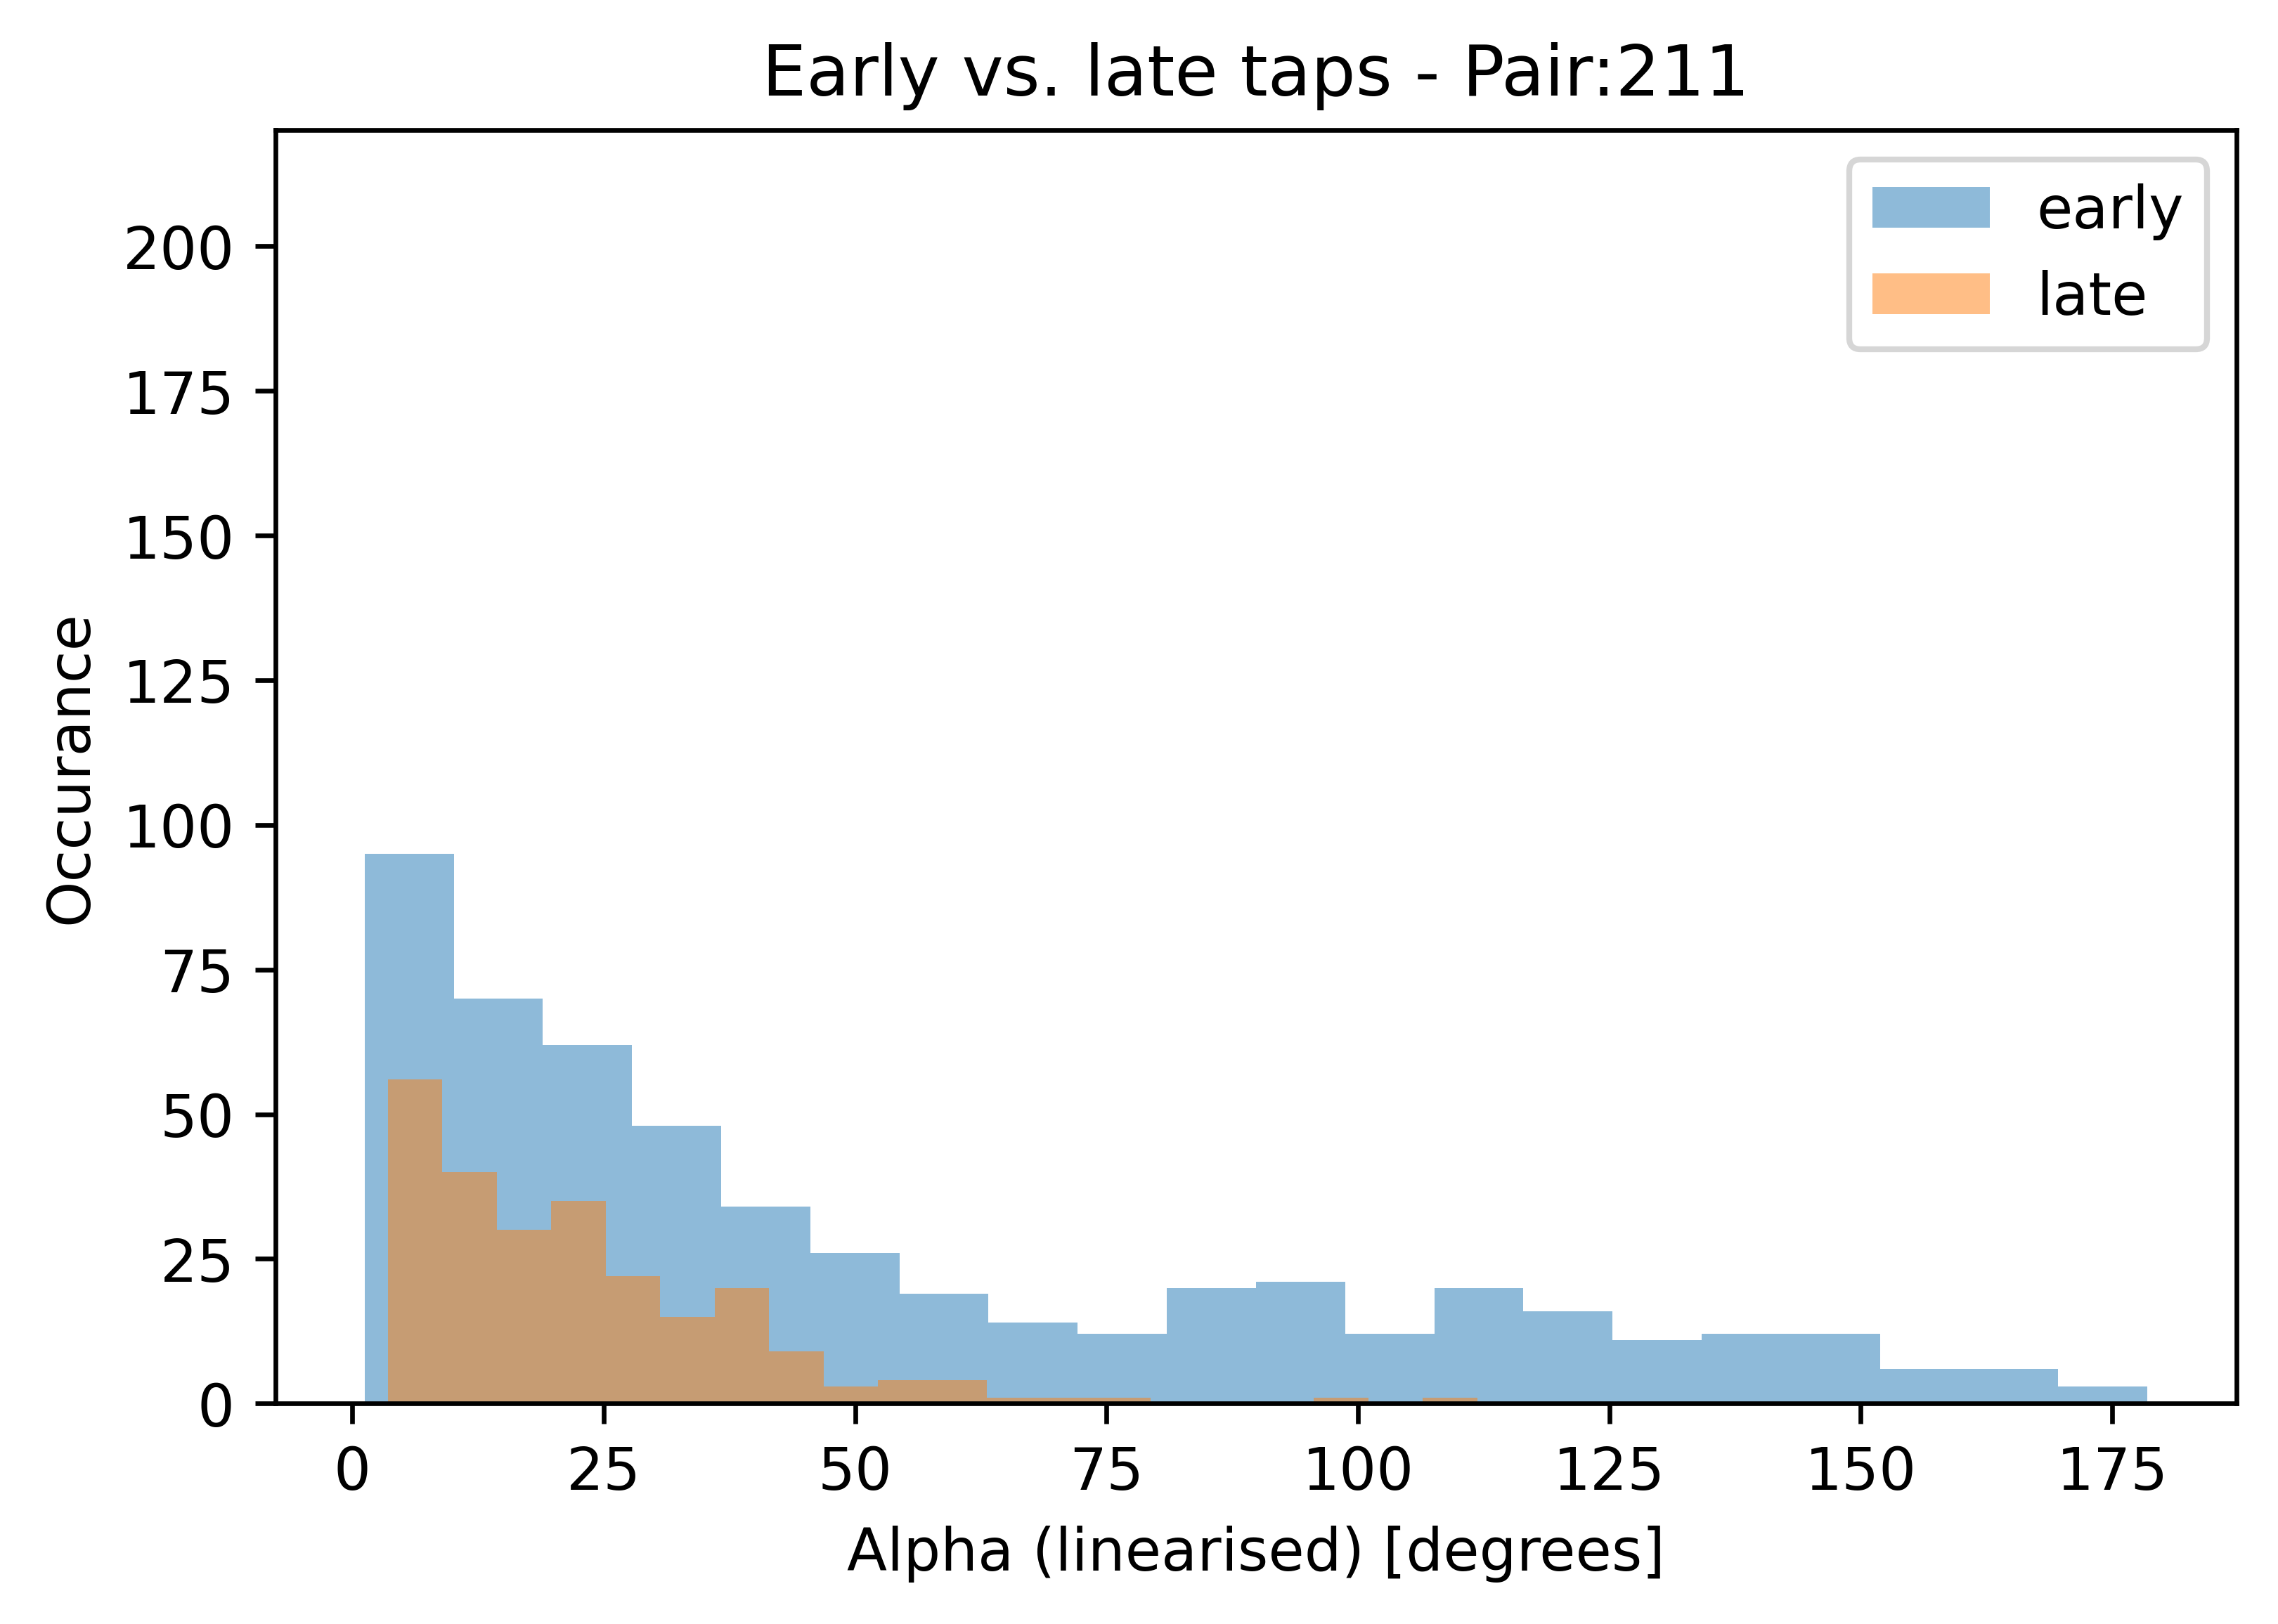

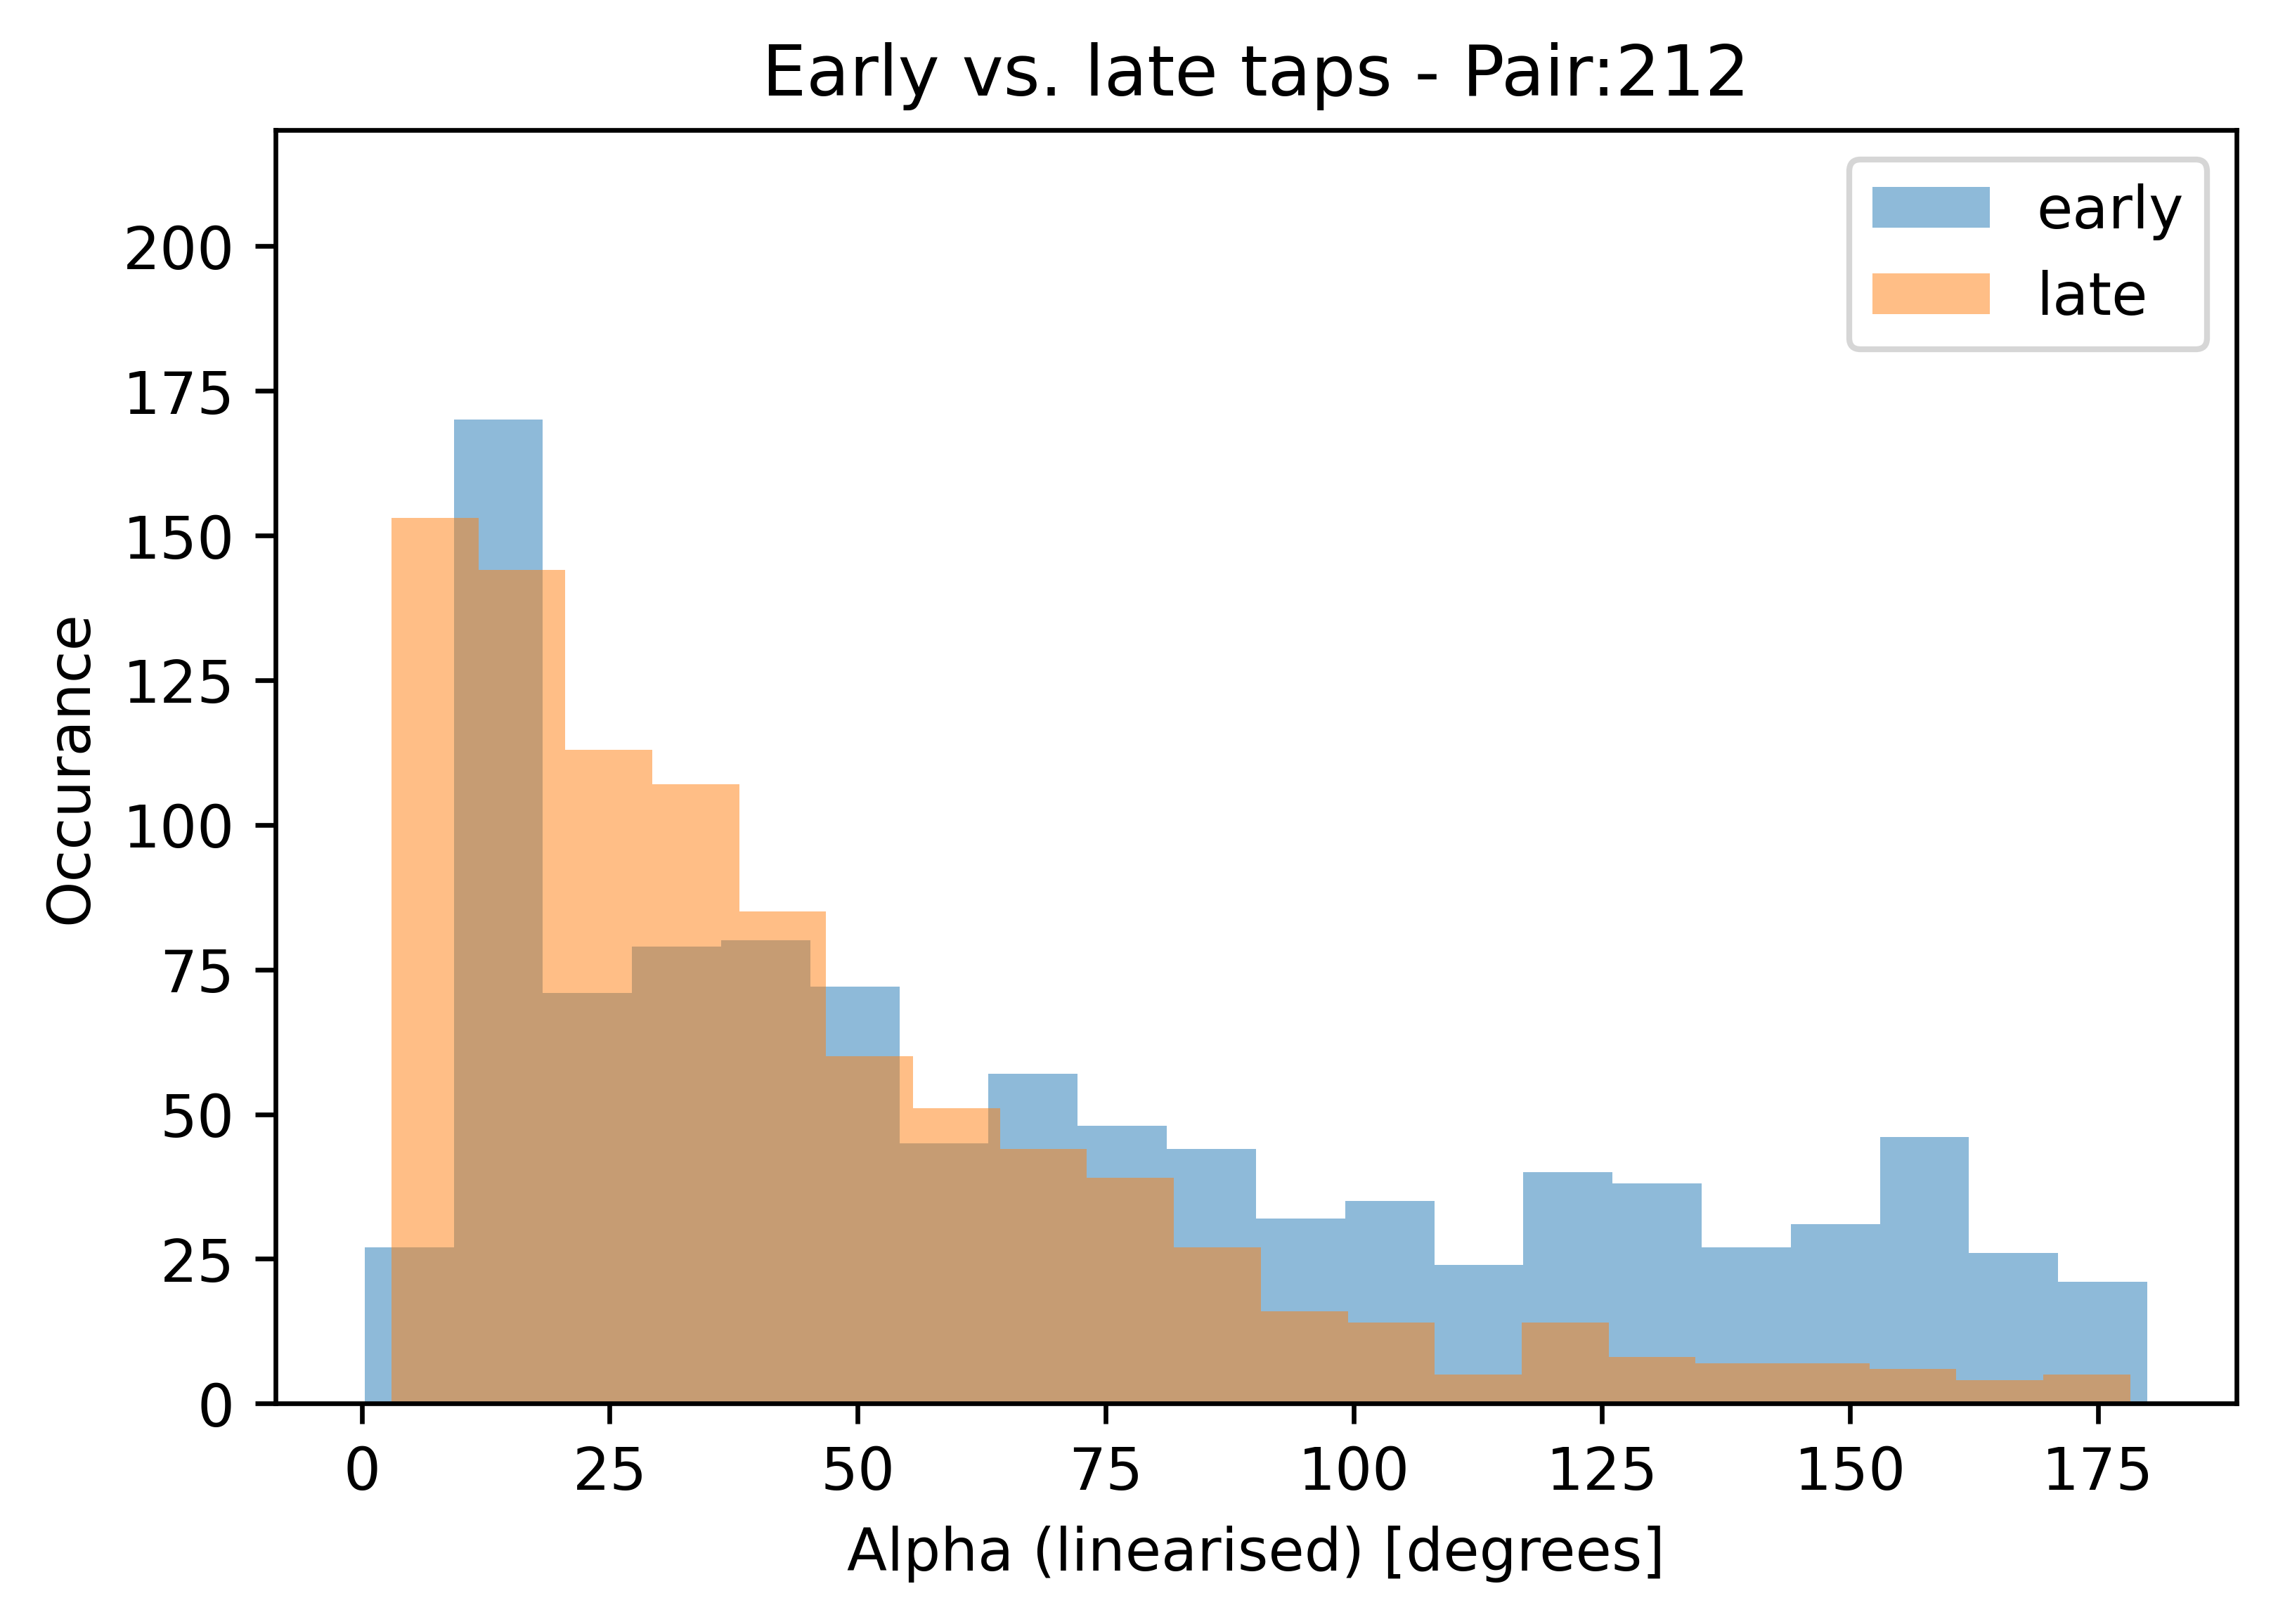

In [30]:
#all_subs = all_subs[all_subs["alpha"] <= 360]

for i in first.pair.unique():
    plt.figure(dpi=600)
    first[first['pair']==i].alpha_lin.hist(bins=20, alpha=0.5, label='early', grid=False)
    last[last['pair']==i].alpha_lin.hist(bins=20, alpha=0.5, label='late', grid=False)
    plt.title(f'Early vs. late taps - Pair:{i}')
    plt.xlabel('Alpha (linearised) [degrees]')
    plt.ylabel('Occurance')
    plt.ylim(0,220)
    
    #mean_f = np.around(np.mean(first[first['pair']==i].alpha_lin),decimals=2)
    #median_f = np.around(np.median(first[first['pair']==i].alpha_lin),decimals=2)
    #mode_f, xyz_f = stats.mode(np.around(first[first['pair']==i].alpha_lin, decimals=2))
    #
    #mean_l = np.around(np.mean(last[last['pair']==i].alpha_lin),decimals=2)
    #median_l = np.around(np.median(last[last['pair']==i].alpha_lin),decimals=2)
    #mode_l, xyz_l = stats.mode(np.around(last[last['pair']==i].alpha_lin, decimals=2))
    #
    #plt.vlines(mean_f,ymin=0,ymax=220, label='mean',color='g')
    #plt.vlines(median_f,ymin=0,ymax=220, label='median',color='b')
    #plt.vlines(mode_f,ymin=0,ymax=220, label='mode',color='r')
    #plt.vlines(mean_l,ymin=0,ymax=220, label='mean',color='g')
    #plt.vlines(median_l,ymin=0,ymax=220, label='median',color='b')
    #plt.vlines(mode_l,ymin=0,ymax=220, label='mode',color='r')
    plt.legend()